<a href="https://colab.research.google.com/github/realmistic/pysteps-basic-fin-analysis/blob/master/Part5_All_history_EPS_estimates_vs_actual_and_long_term_returns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EPS definition: https://www.investopedia.com/terms/e/eps.asp <br>
Relationship between EPS and Stock Price: https://finance.zacks.com/relationship-between-earnings-stock-market-value-4890.html#:~:text=The%20direct%20relationship%20between%20the,P%2FE%20would%20be%2050.
<br>

**The idea**: check long-term performance of ERS predicted vs. reported and its influence on a stock apice 

<br> We try to answer on several questions:
*  Do all companies try to report very close to estimates? What is big enough to cause a shock in a short-time earnings? 
*  If the spike caused a rapid increase change in the stock price -> does it remain for a several days?
*  Does consistent reporting of a slight positive surprise bring to long-term stocks growth?
*  Does a gradual increase in EPS increase the valuation of a company? 

<br> The ultimate goal: to find a segment of stocks which has a high probability of growth during the several days after the announcement of quarterly results

# Prepare - links

**USEFUL LINKS:** 
  * **29-Oct**: FB earnings call
  * Better implement this for estimations and more recent stats on actuals: https://www.nasdaq.com/market-activity/stocks/goog/earnings
  * **size effect** : small firms outperform large firms
  * **the value effect** : firms with low valuation metrics outperform their counterparties with opp characteristics
  * **momentum effect** : (Cliffors Asness - late 80's) : stocks with good momentum (in terms of 6-12 months returns), have higher returns going forward than poor momentum with a similar market risk

* Scrape WIKI stock tickers
  * https://en.wikipedia.org/wiki/List_of_S%26P_500_companies
  * https://en.wikipedia.org/wiki/NASDAQ-100#Components
  * https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average#Components

* Best Github repos and Git book:
  * https://git-scm.com/book/ru/v2
  * MML-book - github.io : https://github.com/mml-book/mml-book.github.io
  * McsML/ml_basics: https://github.com/mcsml/ml_basics
  * ageron/handson-ml2: https://github.com/ageron/handson-ml2
    *  WORK IN PROGRESS FOLDER
  * (colab) ageron/handson-ml2:  https://colab.research.google.com/github/ageron/handson-ml2/blob/master/01_the_machine_learning_landscape.ipynb#scrollTo=oBqtPgLXQ4eB
  * Mastering Markdown: https://guides.github.com/features/mastering-markdown/
  * **[Ivan's] Pysteps basic fin analysis: https://github.com/realmistic/pysteps-basic-fin-analysis**
  * Stefan Jansen Hands-on-Machine-Learning-for-Algorithmic-Trading: https://github.com/stefan-jansen/machine-learning-for-trading


  * Compare RU brokers (by BY folks):
  https://docs.google.com/spreadsheets/d/1eerLBXsBOVoCy_w0o9cuJtQaMdBTyTToXmnMHeS3POw/edit#gid=0
  * Compare EU brokers:
   https://brokerchooser.com/compare-brokerage : DEGIRO, IBKR, REVOLUT

  * NICE Dynamic graph: https://coinmarketcap.com/currencies/bitcoin/
   


**USEFUL LINKS 2**

* Medalion history: https://medium.com/@63ey5f4uw3k42v1exp7/chronology-mercer-medallion-fund-9aa719ceeb4f
* ATVI hist EPS: https://finance.yahoo.com/calendar/earnings?symbol=atvi
* AVTI stock perf link: https://www.infrontanalytics.com/fe-EN/31752NU/Activision-Blizzard-Inc-/stock-performance
* ATVI and TakeTwo old games remakes: https://www.fool.com/investing/2020/06/29/why-activision-blizzard-take-two-like-remake-games.aspx
* INTC hist EPS: https://finance.yahoo.com/calendar/earnings?symbol=intc
* EA hist EPS: https://finance.yahoo.com/calendar/earnings?symbol=ea
* TTWO hist EPS: https://finance.yahoo.com/calendar/earnings?symbol=ttwo
* TTWO earnings: https://www.nasdaq.com/market-activity/stocks/ttwo/earnings

* **MOST ACTIVE STOCKS** https://finance.yahoo.com/most-active?count=100
* **TOP ETFs Today** https://finance.yahoo.com/etfs



# 0) Imports & Const
A standard set of analytical, scrapping, and finance imports
We create here a set of tickers to be included to the analysis


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

In [ ]:
!pip install beautifulsoup4

In [ ]:
ADDITIONAL_TICKERS = ['CAT', 'SNAP', 'TSLA', 'GE', 'GOOG', 'FB', 'AMD','ATVI','SAP','EBAY']

# 1) Functions to scrape one page and clean the missing values
Reusing the approach from Article4 on scrapping one page with one table, and cleaning it up. <br>
**get_scraped_yahoo_finance_page()** is similar to what we had before in Part4:
  * takes URL and URL_PARAMs as input arguments
  * Finds one existing table in the HTML table
  * Saves the table column manes (there is one hack for Most-active page, as one column is not visible)
  * Retrieves the values row-by-row
  * Returns a dataframe with all fields as an object

**clean_earnings_history_df()** : removes all cells with missing values ('-') 

In [ ]:
# Example of a full URL with one stock Symbol
# url = "https://finance.yahoo.com/calendar/earnings?symbol=ATVI"

def get_scraped_yahoo_finance_page(url,url_params):
  # url = "https://finance.yahoo.com/calendar/earnings"
  # url_params = {'symbol':ticker}
  r = requests.get(url,params=url_params)
  # DEBUG:
  # print('Response OK? :',r.ok)
  # print('Status code:', r.status_code )
  # print('Headers:', r.headers)
  # print('Content:', r.content)
 
  soup = BeautifulSoup(r.text)
  table = soup.find_all('table')
  # DEBUG: Just 1 table found which is good
  print('We\'ve found tables:', len(table))
  if len(table)!=1:
    return None
  # Get all column names
  if len(soup.table.find_all('thead'))==0:
    return None

  spans = soup.table.thead.find_all('span')
  columns = []
  for span in spans:
    columns.append(span.text)

  # Hack: due to some reason one of the columns are not <span> tag for calendar/earnings and is not discovered in the columns list. 
  # we manually add this column 
  if url.find('https://finance.yahoo.com/most-active') != -1 :
    columns.insert(len(columns)-2,"Market Cap")

  rows = soup.table.tbody.find_all('tr')  
  # read row by row
  stocks_df = pd.DataFrame(columns=columns)

  for row in rows:
    elems = row.find_all('td')
    dict_to_add = {}
    for i,elem in enumerate(elems):
      dict_to_add[columns[i]] = elem.text
    stocks_df = stocks_df.append(dict_to_add, ignore_index=True)  

  return stocks_df


# The only record per stock appears with this patern : the next earnings date
def get_next_earnings_records(stocks_df):
  filter1 = stocks_df['EPS Estimate']!='-'
  filter2 = stocks_df['Surprise(%)']=='-'
  filter3 = stocks_df['Reported EPS']=='-'
  rez_df = stocks_df[filter1 & filter2 & filter3]
  return rez_df

# Remove all records with not filled stats and cast to float values
def clean_earnings_history_df(stocks_df):
  filter1 = stocks_df['EPS Estimate']!='-'
  filter2 = stocks_df['Surprise(%)']!='-'
  filter3 = stocks_df['Reported EPS']!='-'
  stocks_df_noMissing = stocks_df[filter1 & filter2 & filter3]
  stocks_df_noMissing['EPS Estimate'] = stocks_df_noMissing['EPS Estimate'].astype(float)
  stocks_df_noMissing['Reported EPS'] = stocks_df_noMissing['Reported EPS'].astype(float)
  stocks_df_noMissing['Surprise(%)'] = stocks_df_noMissing['Surprise(%)'].astype(float)
  return stocks_df_noMissing



In [ ]:
# Checking the functions: get the stats for ATVI (Activision Blizzard)
ticker = 'ATVI'
atvi_df = get_scraped_yahoo_finance_page(url = "https://finance.yahoo.com/calendar/earnings",url_params = {'symbol':ticker})
atvi_df_clean = clean_earnings_history_df(atvi_df)

We've found tables: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [ ]:
# Checking the functions: getting the stats for F (Ford)
ticker = 'F'
f_df = get_scraped_yahoo_finance_page(url = "https://finance.yahoo.com/calendar/earnings",url_params = {'symbol':ticker})
f_df_clean = clean_earnings_history_df(f_df)

We've found tables: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [ ]:
# Ford had great results recently
f_df_clean

Symbol             Company  ... Reported EPS  Surprise(%)
4       F  Ford Motor Company  ...         0.65       238.54
5       F  Ford Motor Company  ...        -0.35        70.19
6       F  Ford Motor Company  ...        -0.23       -88.52
7       F  Ford Motor Company  ...         0.12       -20.53
8       F  Ford Motor Company  ...         0.34        30.77
..    ...                 ...  ...          ...          ...
95      F  Ford Motor Company  ...         1.45        19.45
96      F  Ford Motor Company  ...         0.90         6.85
97      F  Ford Motor Company  ...         1.98         8.05
98      F  Ford Motor Company  ...         1.20        39.00
99      F  Ford Motor Company  ...         1.10        12.74

[95 rows x 6 columns]

In [ ]:
# IMPORTANT TO GET THE NEXT DATE AND EPS Estimate
atvi_df.head()

Symbol                    Company  ... Reported EPS Surprise(%)
0   ATVI    Activision Blizzard Inc  ...            -           -
1   ATVI    Activision Blizzard Inc  ...            -           -
2   ATVI    Activision Blizzard Inc  ...            -           -
3   ATVI    Activision Blizzard Inc  ...            -           -
4   ATVI  Activision Blizzard, Inc.  ...         0.71       +9.74

[5 rows x 6 columns]

In [ ]:
atvi_df_clean.head(10)

Symbol                    Company  ... Reported EPS  Surprise(%)
4    ATVI  Activision Blizzard, Inc.  ...         0.71         9.74
5    ATVI  Activision Blizzard, Inc.  ...         0.97        41.61
6    ATVI  Activision Blizzard, Inc.  ...         0.58        53.44
7    ATVI  Activision Blizzard, Inc.  ...         1.23         3.36
8    ATVI  Activision Blizzard, Inc.  ...         0.32        37.34
9    ATVI  Activision Blizzard, Inc.  ...         0.38        46.72
10   ATVI  Activision Blizzard, Inc.  ...         0.31        25.00
11   ATVI  Activision Blizzard, Inc.  ...         1.29         0.55
12   ATVI  Activision Blizzard, Inc.  ...         0.52         4.00
13   ATVI  Activision Blizzard, Inc.  ...         0.41        16.48

[10 rows x 6 columns]

In [ ]:
atvi_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 4 to 99
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Symbol         84 non-null     object 
 1   Company        84 non-null     object 
 2   Earnings Date  84 non-null     object 
 3   EPS Estimate   84 non-null     float64
 4   Reported EPS   84 non-null     float64
 5   Surprise(%)    84 non-null     float64
dtypes: float64(3), object(3)
memory usage: 4.6+ KB


# 2) Get top 200 Traded stocks

Get the 200 most active stocks during the last trading day.
The list (in conjunction with the selected stocks) will be used to get the historical values of EPS and future returns on the dates of EPS (to test the hypothesis if good or bad EPS predict good returns).

We apply the  regex approach to convert all text values to numeric symbols(% values and magnitude M,B,T).

In [ ]:
# Get top-200 (at max) traded stocks
# Getting an ATVI stats 
num_stocks = 200
most_active_stocks = get_scraped_yahoo_finance_page(url = "https://finance.yahoo.com/most-active",url_params = {'count':num_stocks})
# atvi_df_clean = clean_earnings_history_df(atvi_df)

We've found tables: 1


In [ ]:
most_active_stocks.head(10)

Symbol                          Name  ... PE Ratio (TTM) 52 Week Range
0    NIO                   NIO Limited  ...            N/A              
1     GE      General Electric Company  ...          27.73              
2   XPEV                    XPeng Inc.  ...            N/A              
3   AAPL                    Apple Inc.  ...          35.77              
4   PLTR    Palantir Technologies Inc.  ...            N/A              
5    PFE                   Pfizer Inc.  ...          23.86              
6    AAL  American Airlines Group Inc.  ...            N/A              
7      F            Ford Motor Company  ...            N/A              
8    CCL    Carnival Corporation & Plc  ...            N/A              
9     LI                  Li Auto Inc.  ...            N/A              

[10 rows x 10 columns]

In [ ]:
# All data types are object ==> it is not integer or float, you can't make arifmetic operations with it!
most_active_stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Symbol             200 non-null    object
 1   Name               200 non-null    object
 2   Price (Intraday)   200 non-null    object
 3   Change             200 non-null    object
 4   % Change           200 non-null    object
 5   Volume             200 non-null    object
 6   Avg Vol (3 month)  200 non-null    object
 7   Market Cap         200 non-null    object
 8   PE Ratio (TTM)     200 non-null    object
 9   52 Week Range      200 non-null    object
dtypes: object(10)
memory usage: 15.8+ KB


In [ ]:
# https://stackoverflow.com/questions/7312020/why-wont-re-groups-give-me-anything-for-my-one-correctly-matched-group
import re

POWERS = {'T': 10 ** 12,'B': 10 ** 9, 'M': 10 ** 6, '%': 0.01, '1':1}

"""Read a string (with M/B/T/% values)
   Return a correct numeric value
"""
def convert_str_to_num(num_str):
   match = re.search(r"([0-9\.-]+)(M|B|T|%)?", num_str)
   if match is None:
     return None
   else:   
     quantity = match.group(1)
     if match.group(2) is None:
       magnitude = '1' # no modificator in the end -> don't multiply on anything
     else:  
       magnitude = match.group(2)
    #  print(quantity, magnitude)
     return float(quantity) * POWERS[magnitude]

In [ ]:
# Testing the function : return all numeric values, except cases when can't convert (not a number)
print(convert_str_to_num("149.981M"))
print(convert_str_to_num("+0.64%"))
print(convert_str_to_num("-0.0600"))
print(convert_str_to_num("1.573T"))
print(convert_str_to_num("N/A"))

149981000.0
0.0064
-0.06
1573000000000.0
None


In [ ]:
columns_to_apply = [ 'Price (Intraday)',  'Change',  '% Change',  'Volume',  'Avg Vol (3 month)',  'Market Cap',
 'PE Ratio (TTM)']


"""Apply column-by-column the function which transforms 
"""
for col in columns_to_apply:
  most_active_stocks[col] = most_active_stocks[col].apply(convert_str_to_num)

In [ ]:
most_active_stocks

Symbol                          Name  ...  PE Ratio (TTM)  52 Week Range
0      NIO                   NIO Limited  ...             NaN               
1       GE      General Electric Company  ...           27.73               
2     XPEV                    XPeng Inc.  ...             NaN               
3     AAPL                    Apple Inc.  ...           35.77               
4     PLTR    Palantir Technologies Inc.  ...             NaN               
..     ...                           ...  ...             ...            ...
195    MAR  Marriott International, Inc.  ...          221.71               
196     PE          Parsley Energy, Inc.  ...             NaN               
197     FL             Foot Locker, Inc.  ...           21.42               
198    USB                  U.S. Bancorp  ...           14.12               
199    EQT               EQT Corporation  ...             NaN               

[200 rows x 10 columns]

In [ ]:
most_active_stocks["log_market_cap"] = np.log10(most_active_stocks["Market Cap"])

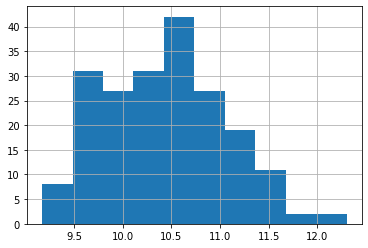

In [ ]:
most_active_stocks.log_market_cap.hist(bins = 10)

In [ ]:
# Dividing the active stocks on 3 equal sized groups
most_active_stocks["log_market_cap_binned"] = pd.qcut(most_active_stocks.log_market_cap,3)

In [ ]:
most_active_stocks

Symbol  ...        log_market_cap_binned
0      NIO  ...               (10.646, 12.3]
1       GE  ...               (10.646, 12.3]
2     XPEV  ...             (10.116, 10.646]
3     AAPL  ...               (10.646, 12.3]
4     PLTR  ...             (10.116, 10.646]
..     ...  ...                          ...
195    MAR  ...             (10.116, 10.646]
196     PE  ...  (9.171000000000001, 10.116]
197     FL  ...  (9.171000000000001, 10.116]
198    USB  ...               (10.646, 12.3]
199    EQT  ...  (9.171000000000001, 10.116]

[200 rows x 12 columns]

In [ ]:
# 3 approx. equal groups on size 66-67 stocks

In [ ]:
most_active_stocks.log_market_cap_binned.value_counts()

(10.646, 12.3]                 67
(9.171000000000001, 10.116]    67
(10.116, 10.646]               66
Name: log_market_cap_binned, dtype: int64

* Average values
    * 1) % Change : largest stocks changes 0.7%, while smaller stocks 2.8%
    * 2) Total volume can be comparable of trade, but market cap differs 5-10x each (5.6*10^9 vs. 2.2*10^10 vs. 2.17*10^11)
    * 3) P/E Ratio (where filled) :is very high for the largest stocks, moderate for smaller, and high again for small

In [ ]:
most_active_stocks.groupby(by='log_market_cap_binned').mean()

Price (Intraday)  ...  log_market_cap
log_market_cap_binned                          ...                
(9.171000000000001, 10.116]         20.481045  ...        9.750206
(10.116, 10.646]                    40.814242  ...       10.414527
(10.646, 12.3]                     102.763054  ...       11.140905

[3 rows x 8 columns]

In [ ]:
print('Small stocks group (9.335, 10.019] is between $', round(10**9.3 /1e9,1), 'B and $', round(10**10.019 /1e9,1),'B  market cap')
print('Mid range stocks group (10.019, 10.624] is between $', round(10**10.019 /1e9,1), 'B and $', round(10**10.624 /1e9,1),'B USD market cap')
print('Large stocks group (10.624, 12.3] is between $', round(10**10.624 /1e9,1), 'B and $', round(10**12.3 /1e9,1),'B USD market cap')

Small stocks group (9.335, 10.019] is between $ 2.0 B and $ 10.4 B  market cap
Mid range stocks group (10.019, 10.624] is between $ 10.4 B and $ 42.1 B USD market cap
Large stocks group (10.624, 12.3] is between $ 42.1 B and $ 1995.3 B USD market cap


In [ ]:
# Now it is a good dataframe with float values where needed
most_active_stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Symbol                 200 non-null    object  
 1   Name                   200 non-null    object  
 2   Price (Intraday)       200 non-null    float64 
 3   Change                 200 non-null    float64 
 4   % Change               200 non-null    float64 
 5   Volume                 200 non-null    float64 
 6   Avg Vol (3 month)      200 non-null    float64 
 7   Market Cap             200 non-null    float64 
 8   PE Ratio (TTM)         99 non-null     float64 
 9   52 Week Range          200 non-null    object  
 10  log_market_cap         200 non-null    float64 
 11  log_market_cap_binned  200 non-null    category
dtypes: category(1), float64(8), object(3)
memory usage: 17.6+ KB


In [ ]:
# Remove outliers : top-xx % from earch sides
# https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame

def remove_outliers(df, column_name, quantile_threshold):
  q_low = df[column_name].quantile(quantile_threshold)
  q_hi  = df[column_name].quantile(1-quantile_threshold)
  
  rez =  df[(df[column_name] < q_hi) & (df[column_name] > q_low)]
  return rez

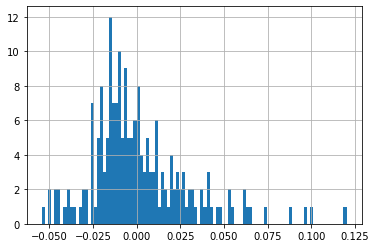

In [ ]:
tmp = remove_outliers(df = most_active_stocks, column_name = "% Change",quantile_threshold = 0.02)
tmp["% Change"].hist(bins=100)

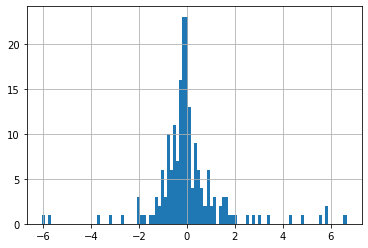

In [ ]:
tmp = remove_outliers(df = most_active_stocks, column_name = "Change",quantile_threshold = 0.02)
tmp["Change"].hist(bins=100)

In [ ]:
most_active_stocks["relative_volume"] = most_active_stocks["Volume"] / most_active_stocks["Avg Vol (3 month)"]

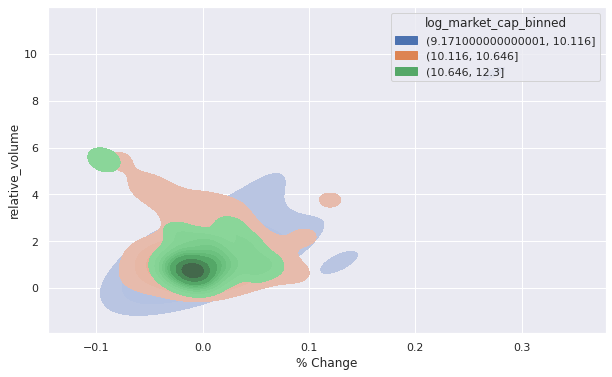

In [ ]:
# [[RESULT 1]] : Last trading day: we split companies on medium, large, and largest (by log_market_cap_binned). 
 # In most cases the 1 day change lies between -10% and +5%, while medium companies can drop even further to -20%
 # It is just one trading day, but it can give a general sense how stock can change its value in one day
 # Relative volume is a share of one day trade divided to average daily trade volume during 3 last months. 
 #  Largest companies are rarely traded more that 1.5x times more than 3-months average, while smaller companies can have up to 2.5x volume (rarely up to 4x)        
              
# https://seaborn.pydata.org/generated/seaborn.kdeplot.html
import seaborn as sns

sns.set(rc={'figure.figsize':(10,6)})

sns.kdeplot(
    data = most_active_stocks, x="% Change", y="relative_volume", hue="log_market_cap_binned", fill=True,
)

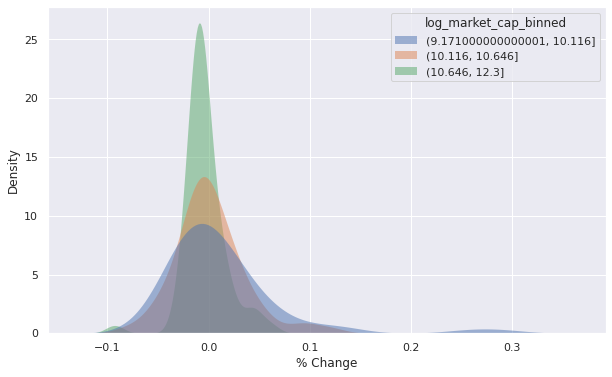

In [ ]:
# The lower is the market value - the bigger is the potential % Change (in one day) and the volatility

# [[RESULT 2]] : Similar to Result1
# Here we can see that medium and large companies tend to have more negative and positive range of returns (although biased to negative) and form a 'wider' bell - with more volatility
# It is an important finding - that you can earn more with smaller companies, but actually you risk more too. So, you return-per-risk can be smaller or bigger vs. largest stocks


# http://seaborn.pydata.org/tutorial/color_palettes.html
sns.set(rc={'figure.figsize':(10,6)})

sns.kdeplot(
   data = most_active_stocks, x="% Change", hue="log_market_cap_binned",
   fill=True, common_norm=False, 
  #  palette="rocket",
   alpha=.5, 
   linewidth=0,
)

# 3) Get a dataframe with all EPS historical for the most traded stocks

We download all available dates for EPS (earnings-per-share) for the most traded stocks 

In [ ]:
most_active_stocks.Symbol

0       NIO
1        GE
2      XPEV
3      AAPL
4      PLTR
       ... 
195     MAR
196      PE
197      FL
198     USB
199     EQT
Name: Symbol, Length: 200, dtype: object

In [ ]:
# ADDITIONAL_TICKERS which didn't appear in the most traded stocks list
NEW_TICKERS = [x for x in ADDITIONAL_TICKERS if x not in set(most_active_stocks.Symbol)]

TICKERS_LIST = most_active_stocks.Symbol.append(pd.Series(NEW_TICKERS))
# type(most_active_stocks.Symbol)append(ADDITIONAL_TICKERS)

In [ ]:
TICKERS_LIST

0       NIO
1        GE
2      XPEV
3      AAPL
4      PLTR
       ... 
198     USB
199     EQT
0       CAT
1      GOOG
2       SAP
Length: 203, dtype: object

In [ ]:
from random import randint
from time import sleep

# Empty dataframe
all_tickers_info = pd.DataFrame({'A' : []})

for i,ticker in enumerate(TICKERS_LIST):
  current_ticker_info = get_scraped_yahoo_finance_page(url = "https://finance.yahoo.com/calendar/earnings",url_params = {'symbol':ticker})
  print(f'Finished with ticker {ticker}, record no {i}')
  if all_tickers_info.empty:
    all_tickers_info = current_ticker_info
  else:
    all_tickers_info = pd.concat([all_tickers_info,current_ticker_info], ignore_index=True) 
  
  # Random sleep 1-3 sec
  sleep(randint(1,3))  

We've found tables: 1
Finished with ticker NIO, record no 0
We've found tables: 1
Finished with ticker GE, record no 1
We've found tables: 1
Finished with ticker XPEV, record no 2
We've found tables: 1
Finished with ticker AAPL, record no 3
We've found tables: 1
Finished with ticker PLTR, record no 4
We've found tables: 1
Finished with ticker PFE, record no 5
We've found tables: 1
Finished with ticker AAL, record no 6
We've found tables: 1
Finished with ticker F, record no 7
We've found tables: 1
Finished with ticker CCL, record no 8
We've found tables: 1
Finished with ticker LI, record no 9
We've found tables: 1
Finished with ticker BAC, record no 10
We've found tables: 1
Finished with ticker WFC, record no 11
We've found tables: 1
Finished with ticker AMD, record no 12
We've found tables: 1
Finished with ticker BABA, record no 13
We've found tables: 1
Finished with ticker VTRS, record no 14
We've found tables: 1
Finished with ticker TSLA, record no 15
We've found tables: 1
Finished w

In [ ]:
all_tickers_info.Symbol.value_counts().head(20)

AAPL    100
BKR     100
F       100
WSM     100
AIG     100
AEP     100
OXY     100
TJX     100
MRK     100
LUV     100
PFE     100
RF      100
WBA     100
TGT     100
NOK     100
LOW     100
M       100
SLB     100
LUMN    100
WFC     100
Name: Symbol, dtype: int64

In [ ]:
next_earnings_dates = get_next_earnings_records(all_tickers_info)

In [ ]:
# [[Tech1]] Closest future earnings dates

# We know when is the next earnings date  ==> what to expect from the closest rev meetings?
next_earnings_dates.sort_values(by='Earnings Date').tail(30)

Symbol                               Company  ... Reported EPS Surprise(%)
7618     CVX                          Chevron Corp  ...            -           -
2920     BBD                   Banco Bradesco S.A.  ...            -           -
2919     BBD                   Banco Bradesco S.A.  ...            -           -
7058     KSS                            Kohls Corp  ...            -           -
9458     TGT                           Target Corp  ...            -           -
8870    VIPS                  Vipshop Holdings Ltd  ...            -           -
1923    PLUG                        Plug Power Inc  ...            -           -
1434     NOK                     Nokia Corporation  ...            -           -
5182     PDD                         Pinduoduo Inc  ...            -           -
4295     PBR  Petróleo Brasileiro S.A. - Petrobras  ...            -           -
12549    PAA    Plains All American Pipeline, L.P.  ...            -           -
3242    VALE                             Vale S.A.  ...            -           -
1716    ITUB            Itaú Unibanco Holding S.A.  ...            -           -
12362    WSM                   Williams-Sonoma Inc  ...            -           -
8041     HST           Host Hotels & Resorts, Inc.  ...            -           -
4294     PBR  Petróleo Brasileiro S.A. - Petrobras  ...            -           -
7511    EQNR                           Equinor ASA  ...            -           -
12255   PEAK           Healthpeak Properties, Inc.  ...            -           -
1717    ITUB            Itaú Unibanco Holding S.A.  ...            -           -
4292     PBR  Petróleo Brasileiro S.A. - Petrobras  ...            -           -
9905    RIDE                Lordstown Motors Corp.  ...            -           -
2134     GSX                       GSX Techedu Inc  ...            -           -
2133     GSX                       GSX Techedu Inc  ...            -           -
13284     FL                       Foot Locker Inc  ...            -           -
10568    HPQ                                HP Inc  ...            -           -
6859     JWN                         Nordstrom Inc  ...            -           -
11349    DKS             Dick's Sporting Goods Inc  ...            -           -
4795      ZM         Zoom Video Communications Inc  ...            -           -
3791       C                        Citigroup Inc.  ...            -           -
13134    IBN                    ICICI Bank Limited  ...            -           -

[30 rows x 6 columns]

In [ ]:
# next_earnings_dates.to_excel("excel_next_earnings_dates_03102020.xlsx",index=False)

In [ ]:
# [[Tech2]] All historical values for EPS Actual, EPS Estimated, Surprise(%) - clean values
all_tickers_info_clean = clean_earnings_history_df(all_tickers_info)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [ ]:
all_tickers_info_clean

Symbol      Company  ... Reported EPS  Surprise(%)
0        NIO  NIO Limited  ...        -0.82        26.13
1        NIO  NIO Limited  ...        -1.08        41.21
2        NIO  NIO Limited  ...        -1.60        13.51
3        NIO  NIO Limited  ...        -2.73       -48.53
4        NIO  NIO Limited  ...        -2.38         1.98
...      ...          ...  ...          ...          ...
13794    SAP       SAP SE  ...         0.13        11.83
13795    SAP       SAP SE  ...         0.08         3.45
13796    SAP       SAP SE  ...         0.21       -31.38
13797    SAP       SAP SE  ...         0.07       -13.33
13798    SAP       SAP SE  ...         0.12        17.95

[12636 rows x 6 columns]

In [ ]:
  # [[RESULT 3]]
  # Interesting comparison: in average EPS estimate is only 0.52, which is not far from the reality 0.50, and an average 1.2% surprise
       # the standard diviation is 386% - which says that there are many outliers can massively under- or overperform 
  # For small values EPS (<0.12) firms tend to under-report on EPS (-0.9% surprise), 
  #  for medium (EPS=0.36) the slightly overreport 3.79% higher than estimate, 
  #  for the highest quantile (EPS>0.71) they over-report in average 13%

In [ ]:
agg_stats = all_tickers_info_clean[['EPS Estimate','Reported EPS']].describe()
all_tickers_info_clean.describe().transpose()

count      mean         std  ...   50%    75%      max
EPS Estimate  12636.0  0.524160    1.486637  ...  0.36   0.71    32.42
Reported EPS  12636.0  0.505667    3.147578  ...  0.38   0.75    35.40
Surprise(%)   12636.0  1.246669  386.027189  ...  3.79  13.45  6900.00

[3 rows x 8 columns]

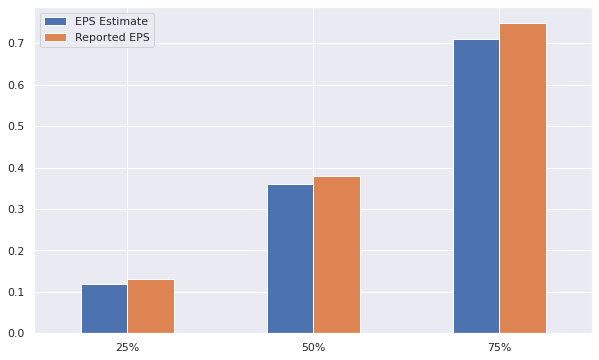

In [ ]:
# [[RESULT 3-2]] Visual graph for 25%-50%-75% quartile

# We visualise the "normal" case (25%,50%,75% quantile) exluding outliers: 
agg_stats.iloc[4:7].plot.bar(rot=0)

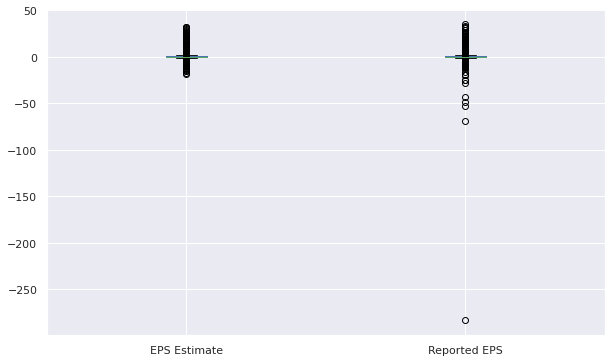

In [ ]:
# Probably (to be checked), this "normal" points when EPS Estimate is close to the Reported EPS won't give us the outstanding returns when everything is happenning as predicted 
  # So we can see from this graph (box plot), that there are many outliers with highly positive or negative EPS Estimate/Reported EPS

all_tickers_info_clean[['EPS Estimate','Reported EPS']].plot.box()

In [ ]:
all_tickers_info_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12636 entries, 0 to 13798
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Symbol         12636 non-null  object 
 1   Company        12636 non-null  object 
 2   Earnings Date  12636 non-null  object 
 3   EPS Estimate   12636 non-null  float64
 4   Reported EPS   12636 non-null  float64
 5   Surprise(%)    12636 non-null  float64
dtypes: float64(3), object(3)
memory usage: 691.0+ KB


In [ ]:
# If we remove 360 entries with extreme values (abs. z-score>2) - then we can have a better view on the box-plot : less outliers in both directions remain

# https://www.kite.com/python/answers/how-to-remove-outliers-from-a-pandas-dataframe-in-python

import scipy

# calculate z-scores of `df`
z_scores = scipy.stats.zscore(all_tickers_info_clean[['EPS Estimate','Reported EPS']])

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 2).all(axis=1)
new_df = all_tickers_info_clean[['EPS Estimate','Reported EPS']][filtered_entries]

new_df

EPS Estimate  Reported EPS
0             -1.11         -0.82
1             -1.84         -1.08
2             -1.85         -1.60
3             -1.84         -2.73
4             -2.43         -2.38
...             ...           ...
13794          0.12          0.13
13795          0.07          0.08
13796          0.30          0.21
13797          0.08          0.07
13798          0.10          0.12

[12380 rows x 2 columns]

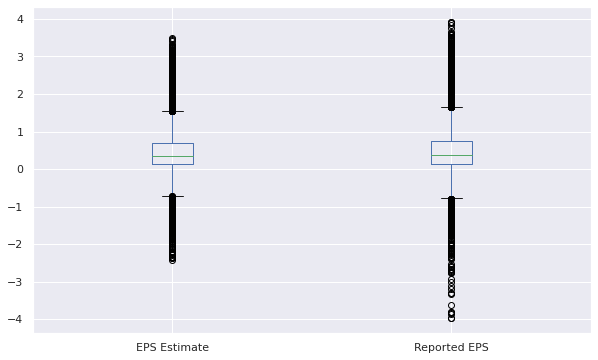

In [ ]:
new_df.plot.box()

In [ ]:
# all_tickers_info_clean.to_csv("all_tickers_info_03102020.csv",index=False)
# all_tickers_info_clean.to_excel("excel_all_tickers_info_03102020.xlsx",index=False)

In [ ]:
from datetime import datetime  
from datetime import timedelta
# Create a new field with a datetime object for the date
# We do not make difference between EDT and EST time --> simply remove it from the end - [:-3] slice from the string

# https://stackabuse.com/how-to-format-dates-in-python/
all_tickers_info_clean['Earnings Date 2'] = all_tickers_info_clean['Earnings Date'].apply(lambda x:datetime.strptime(x[:-3], '%b %d, %Y, %H %p') )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
# Check the conversion to short string version
all_tickers_info_clean["Earnings Date 2"].apply(lambda x : x.strftime('%Y-%m-%d'))

0        2020-11-17
1        2020-08-11
2        2020-05-28
3        2020-03-18
4        2019-12-30
            ...    
13794    1998-10-12
13795    1998-05-26
13796    1998-02-18
13797    1997-11-15
13798    1997-08-15
Name: Earnings Date 2, Length: 12636, dtype: object

In [ ]:
# Generate the PRIMARY KEY (PK) to be used in merge afterwards
# Return back to string the earnings date without time and add ticker symbol
all_tickers_info_clean['PK'] =  all_tickers_info_clean.Symbol + "|"+ all_tickers_info_clean["Earnings Date 2"].apply(lambda x : x.strftime('%Y-%m-%d'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Clean dataframe with historical EPS and PRIMARY KEY to merge
all_tickers_info_clean.head()

Symbol      Company  ...     Earnings Date 2              PK
0    NIO  NIO Limited  ... 2020-11-17 12:00:00  NIO|2020-11-17
1    NIO  NIO Limited  ... 2020-08-11 12:00:00  NIO|2020-08-11
2    NIO  NIO Limited  ... 2020-05-28 12:00:00  NIO|2020-05-28
3    NIO  NIO Limited  ... 2020-03-18 12:00:00  NIO|2020-03-18
4    NIO  NIO Limited  ... 2019-12-30 12:00:00  NIO|2019-12-30

[5 rows x 8 columns]

# 4) Get all available history of stock prices for the selected tickers

In [ ]:
#  https://towardsdatascience.com/free-stock-data-for-python-using-yahoo-finance-api-9dafd96cad2e
# 2000 requests per IP per hour ==> 48k requests per day
!pip install yfinance

     |████████████████████████████████| 5.5MB 6.5MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=a26e267fa2cc4994f18eb929a14f2ae49034f2063224a7afeab6f1f6ecb7d8dc
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import yfinance as yf

In [ ]:
most_active_stocks.Symbol

0       NIO
1        GE
2      XPEV
3      AAPL
4      PLTR
       ... 
195     MAR
196      PE
197      FL
198     USB
199     EQT
Name: Symbol, Length: 200, dtype: object

In [ ]:
TICKERS_LIST

0       NIO
1        GE
2      XPEV
3      AAPL
4      PLTR
       ... 
198     USB
199     EQT
0       CAT
1      GOOG
2       SAP
Length: 203, dtype: object

In [ ]:
# [[Tech3]] Generate table with daily prices and future returns (in 1-7,30,90,360 days)

# Start from an empty dataframe
df_stocks_prices = pd.DataFrame({'A' : []})

# Download all history of stock prices and calculate the future returns for 1-7 days, 30d, 90d, 365d 
# That is: we are very interested if we buy stock at some date (e.g. high EPS) -> if it is going to be a profitable decision
for i,ticker in enumerate(TICKERS_LIST):
  yf_ticker = yf.Ticker(ticker)
  historyPrices = yf_ticker.history(period='max')
  historyPrices['Ticker'] = ticker

  # Sometimes there is a problem with .index value --> use try
  # https://stackoverflow.com/questions/610883/how-to-know-if-an-object-has-an-attribute-in-python
  try:
    historyPrices['Year']= historyPrices.index.year
    historyPrices['Month'] = historyPrices.index.month
    historyPrices['Weekday'] = historyPrices.index.weekday
    historyPrices['Date'] = historyPrices.index.date
  except AttributeError:
    print(historyPrices.index)
  
  # !!! Important: we do historyPrices['Close'].shift(1) - to get the Close market price the day BEFORE current
  # !!! Important: we do historyPrices['Close'].shift(-i)) - to get the Close market price the i days AFTER current
  #   If you divide second on first -> you get the returns from holding "i days" the stock that you bought the day before financial reporting occurred
  
  for i in [1,2,3,4,5,6,7,30,90,365]:
    historyPrices['r_future'+str(i)] = np.log(historyPrices['Close'].shift(-i) / historyPrices['Close'].shift(1) )

  historyPrices['years_from_now'] = historyPrices['Year'].max()- historyPrices['Year']
  historyPrices['ln_volume']= np.log(historyPrices['Volume'])

  if df_stocks_prices.empty:
     df_stocks_prices = historyPrices
  else: 
    df_stocks_prices = pd.concat([df_stocks_prices,historyPrices], ignore_index=True)

  


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

In [ ]:
# Checking the datatypes
# We overuse the memory - as we need in reality only a small portion of dates, where we have the reported EPS
df_stocks_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231484 entries, 0 to 1231483
Data columns (total 24 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   Open            1231462 non-null  float64
 1   High            1231462 non-null  float64
 2   Low             1231462 non-null  float64
 3   Close           1231462 non-null  float64
 4   Volume          1231462 non-null  float64
 5   Dividends       1231484 non-null  float64
 6   Stock Splits    1231484 non-null  float64
 7   Ticker          1231484 non-null  object 
 8   Year            1231484 non-null  int64  
 9   Month           1231484 non-null  int64  
 10  Weekday         1231484 non-null  int64  
 11  Date            1231484 non-null  object 
 12  r_future1       1231035 non-null  float64
 13  r_future2       1230833 non-null  float64
 14  r_future3       1230631 non-null  float64
 15  r_future4       1230429 non-null  float64
 16  r_future5       1230227 non-null  fl

In [ ]:
# We generate the same PRIMARY KEY to (inner) join with the dateframe of EPS : <Symbol, Date> of report identify how we should join
df_stocks_prices["PK"] = df_stocks_prices.Ticker + "|"+ df_stocks_prices["Date"].apply(lambda x : x.strftime('%Y-%m-%d'))

In [ ]:
# we've generated a lot of daily stats (1M records for <200 stocks) for the financial performance of the selected stocks
df_stocks_prices.tail(10)

Open        High  ...  ln_volume              PK
1231474  120.050003  120.099998  ...  14.998433  SAP|2020-11-09
1231475  119.290001  119.300003  ...  14.635070  SAP|2020-11-10
1231476  119.000000  119.730003  ...  14.361143  SAP|2020-11-11
1231477  119.349998  119.620003  ...  14.237964  SAP|2020-11-12
1231478  119.629997  120.430000  ...  13.866299  SAP|2020-11-13
1231479  120.559998  120.690002  ...  13.651932  SAP|2020-11-16
1231480  117.449997  117.650002  ...  14.128568  SAP|2020-11-17
1231481  118.489998  119.459999  ...  14.286014  SAP|2020-11-18
1231482  117.910004  118.680000  ...  14.200705  SAP|2020-11-19
1231483  117.309998  117.709999  ...  14.133237  SAP|2020-11-20

[10 rows x 25 columns]

In [ ]:
# [[Tech3-2]] EXAMPLE: check how r_future1 and r_future2 are calculated for one stock
# CHECK for r_future1: GE stock for 2020-10-16:
    # lets select the second row for the date '2020-10-02' : GE Close price for 2020-10-01 was 6.24, for 10-05 (the next trading day after 10-02) was 6.41, for 10-06 was 6.17
    # r_future1 = log(6.41 / 6.24) = log(1.027) = 0,026  -- that is approximately 2.6% returns from buying stock GE on 1-Oct and selling it 5th Oct (1 trading days after the reporting date)
    # r_future2 = log(6.17 / 6.24) = log(0.988) = -0,011  -- that is approximately -1.1% returns (loss) from buying stock GE on 1-Oct and selling it 6-th Oct (2 trading days after the reporting date) 
    

In [ ]:
filter1 = df_stocks_prices.Ticker=='GE'
filter2 = df_stocks_prices.Year == 2020
filter3 = df_stocks_prices.Month == 10
df_stocks_prices[filter1 & filter2 & filter3].head(10)

Open  High   Low  ...  years_from_now  ln_volume             PK
15343  6.27  6.29  6.11  ...               0  18.187179  GE|2020-10-01
15344  6.05  6.40  6.05  ...               0  18.316169  GE|2020-10-02
15345  6.39  6.45  6.32  ...               0  17.880831  GE|2020-10-05
15346  6.43  6.58  6.11  ...               0  18.951698  GE|2020-10-06
15347  6.22  6.40  6.21  ...               0  18.237792  GE|2020-10-07
15348  6.36  6.67  6.34  ...               0  18.451863  GE|2020-10-08
15349  7.07  7.07  6.70  ...               0  18.960138  GE|2020-10-09
15350  6.92  6.92  6.74  ...               0  18.304556  GE|2020-10-12
15351  6.79  6.82  6.66  ...               0  18.136826  GE|2020-10-13
15352  6.72  6.89  6.72  ...               0  18.401255  GE|2020-10-14

[10 rows x 25 columns]

In [ ]:
# This is a previous dataframe - only 11K entries with specific dates of EPS returns
all_tickers_info_clean.head()

Symbol      Company  ...     Earnings Date 2              PK
0    NIO  NIO Limited  ... 2020-11-17 12:00:00  NIO|2020-11-17
1    NIO  NIO Limited  ... 2020-08-11 12:00:00  NIO|2020-08-11
2    NIO  NIO Limited  ... 2020-05-28 12:00:00  NIO|2020-05-28
3    NIO  NIO Limited  ... 2020-03-18 12:00:00  NIO|2020-03-18
4    NIO  NIO Limited  ... 2019-12-30 12:00:00  NIO|2019-12-30

[5 rows x 8 columns]

In [ ]:
all_tickers_info_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12636 entries, 0 to 13798
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Symbol           12636 non-null  object        
 1   Company          12636 non-null  object        
 2   Earnings Date    12636 non-null  object        
 3   EPS Estimate     12636 non-null  float64       
 4   Reported EPS     12636 non-null  float64       
 5   Surprise(%)      12636 non-null  float64       
 6   Earnings Date 2  12636 non-null  datetime64[ns]
 7   PK               12636 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 888.5+ KB


In [ ]:

# [[Tech 4]] You need to work with removing duplicates for both datasets - in order to correctly join them with 1-to-1 matching (on Primary Key)

# Details about merge (inner join): https://www.shanelynn.ie/merge-join-dataframes-python-pandas-index-1/
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html

# IT SHOULD BE 1-to-1 merge - no duplicates are allowed

In [ ]:
# Unfortunatelly, there are duplicates sometimes - need to get rid of them
all_tickers_info_clean.groupby(by='PK').count().sort_values(by='Symbol').tail(20)

Symbol  Company  ...  Surprise(%)  Earnings Date 2
PK                                ...                              
FL|2001-11-21         1        1  ...            1                1
FL|2002-03-13         1        1  ...            1                1
FL|2002-05-23         1        1  ...            1                1
FL|2002-08-22         1        1  ...            1                1
FL|2002-11-21         1        1  ...            1                1
FL|2003-03-12         1        1  ...            1                1
FL|2003-05-22         1        1  ...            1                1
FL|2003-08-21         1        1  ...            1                1
FL|2003-11-19         1        1  ...            1                1
FL|2004-03-02         1        1  ...            1                1
FL|2004-05-19         1        1  ...            1                1
FL|2004-08-19         1        1  ...            1                1
FL|2004-11-18         1        1  ...            1                1
FL|2005-03-01         1        1  ...            1                1
FL|2005-05-18         1        1  ...            1                1
FL|2005-11-17         1        1  ...            1                1
FL|2006-03-01         1        1  ...            1                1
FL|2006-05-17         1        1  ...            1                1
FL|2006-11-16         1        1  ...            1                1
ZNGA|2020-11-04       1        1  ...            1                1

[20 rows x 7 columns]

In [ ]:
all_tickers_info_clean[all_tickers_info_clean.PK=="KSS|2017-05-11"]	

Symbol             Company  ...     Earnings Date 2              PK
7073    KSS  Kohl's Corporation  ... 2017-05-11 12:00:00  KSS|2017-05-11

[1 rows x 8 columns]

In [ ]:
all_tickers_info_clean[all_tickers_info_clean.PK=="ATUS|2018-02-27"]	

Empty DataFrame
Columns: [Symbol, Company, Earnings Date, EPS Estimate, Reported EPS, Surprise(%), Earnings Date 2, PK]
Index: []

In [ ]:
# [[Tech 4]] You need to work with removing duplicates for both datasets - in order to correctly join them with 1-to-1 matching (on Primary Key)

all_tickers_info_clean = all_tickers_info_clean.drop_duplicates(subset=['PK'], keep='first')

In [ ]:
# [[Tech 4]] You need to work with removing duplicates for both datasets - in order to correctly join them with 1-to-1 matching (on Primary Key)

df_stocks_prices = df_stocks_prices.drop_duplicates(subset=['PK'], keep='first')

In [ ]:
# Trying to merge again - we use one-to-one validation to make sure there are no
merged_df = pd.merge(all_tickers_info_clean, df_stocks_prices, on="PK", validate="one_to_one")

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12252 entries, 0 to 12251
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Symbol           12252 non-null  object        
 1   Company          12252 non-null  object        
 2   Earnings Date    12252 non-null  object        
 3   EPS Estimate     12252 non-null  float64       
 4   Reported EPS     12252 non-null  float64       
 5   Surprise(%)      12252 non-null  float64       
 6   Earnings Date 2  12252 non-null  datetime64[ns]
 7   PK               12252 non-null  object        
 8   Open             12252 non-null  float64       
 9   High             12252 non-null  float64       
 10  Low              12252 non-null  float64       
 11  Close            12252 non-null  float64       
 12  Volume           12252 non-null  float64       
 13  Dividends        12252 non-null  float64       
 14  Stock Splits     12252 non-null  float

In [ ]:

# [[Tech 5]] Example from the resulting dataset for Intel (INTC): it has all the reporting dates AND returns r1-r7,r30,r90,r360_future from the date of earnings
# The resulting dataset : all reported EPS and the financial future returns around the date of report
merged_df[merged_df.Symbol=='INTC']

Symbol            Company  ... years_from_now  ln_volume
1648   INTC  Intel Corporation  ...              0  17.541751
1649   INTC  Intel Corporation  ...              0  17.588699
1650   INTC  Intel Corporation  ...              0  17.373484
1651   INTC  Intel Corporation  ...              0  17.571551
1652   INTC  Intel Corporation  ...              1  16.968802
...     ...                ...  ...            ...        ...
1738   INTC  Intel Corporation  ...             22  18.393803
1739   INTC  Intel Corporation  ...             23  18.289537
1740   INTC  Intel Corporation  ...             23  18.740228
1741   INTC  Intel Corporation  ...             23  18.857583
1742   INTC  Intel Corporation  ...             23  18.550593

[95 rows x 32 columns]

# 5) Individual stocks examples: recent spikes in Q3 and Q2 reports

To cover: 
* [TSLA] https://www.cnbc.com/2020/10/21/tesla-tsla-earnings-q3-2020.html
* [GE] shares jump after company posts surprise adjusted third-quarter profit, revenue tops expectations https://www.cnbc.com/2020/10/28/general-electric-ge-earnings-q3-2020.html
* [FB] stocks earned 6% after Q2 report date and 10% after Q1 report https://www.cnbc.com/2020/04/29/facebook-fb-earnings-q1-2020.html#:~:text=Here's%20what%20Facebook%20reported%3A,Revenue%3A%20%2417.74%20billion
https://www.cnbc.com/2020/07/30/facebook-fb-earnings-q2-2020.html#:~:text=Here's%20what%20Facebook%20reported%3A,Revenue%3A%20%2418.7%20billion%20vs.
* [GOOG]
* [CAT] dropped 25% in rev on Tue: https://www.zerohedge.com/markets/caterpillar-slides-lack-guidance-despite-revenue-eps-beats
* [AMD] https://www.anandtech.com/show/16198/amd-reports-q3-2020-earnings-making-money-and-settings-records-yet-again

In [ ]:
def draw_plot(symbol):
  filter = (merged_df.Symbol== symbol) & (merged_df.Year>=2010)
  df = merged_df[filter][["EPS Estimate","Reported EPS","Surprise(%)","r_future1","r_future7","Date"]]
  with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df.head(15))
  df[["EPS Estimate","Reported EPS","Date"]].plot.line(x="Date", figsize=(20,6), title=" EPS Estimate vs. Reported")
  df[["Surprise(%)","Date"]].plot.line(x="Date", figsize=(20,6), title="Surprise % (=Reported EPS/EPS Estimate)")
  df[["r_future1","r_future7","Date"]].sort_values(by='Date').plot(x="Date", kind='bar', figsize=(20,6), title="Stock jump")
  # ax = df[['Date', "EPS Estimate","Reported EPS"]].plot(
  #   x='Date', linestyle='-', marker='o')
  # df[['Date', 'r_future1']].plot(x='Date', kind='bar', ax=ax)


      EPS Estimate  Reported EPS  Surprise(%)  r_future1  r_future7  \
1648          1.11          1.11         0.27  -0.104323  -0.185092   
1649          1.11          1.23        10.71  -0.187939  -0.234262   
1650          1.28          1.45        13.46  -0.014075  -0.035739   
1651          1.25          1.52        21.60   0.087556   0.026584   
1652          1.24          1.42        14.52   0.087688   0.107852   
1653          0.89          1.06        18.57  -0.025453  -0.119272   
1654          0.87          0.89         2.42  -0.113301  -0.130545   
1655          1.22          1.28         4.66  -0.018952   0.026350   
1656          1.15          1.40        21.53   0.074260   0.122956   
1657          0.96          1.04         8.45  -0.094967  -0.055492   
1658          0.72          0.87        21.00   0.025936   0.043005   
1659          0.87          1.08        24.86   0.095690  -0.021993   
1660          0.80          1.01        25.78   0.085048   0.141461   
1661  

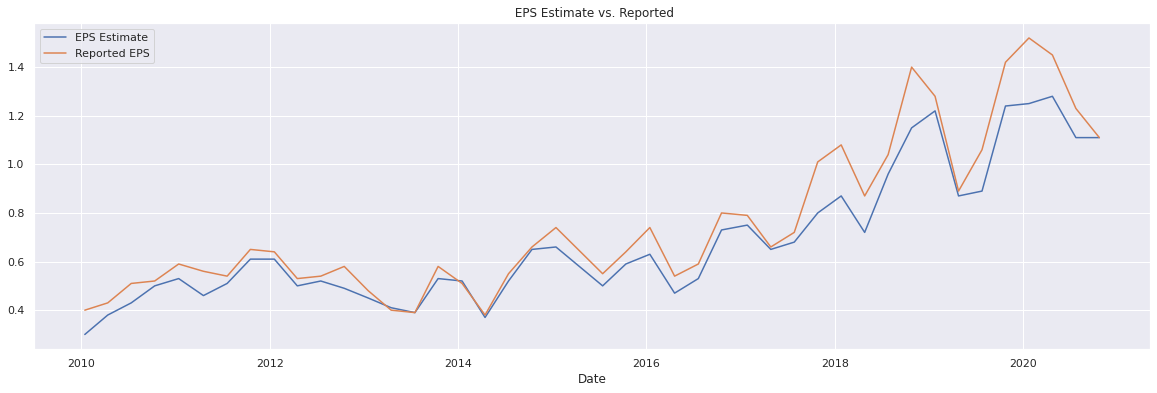

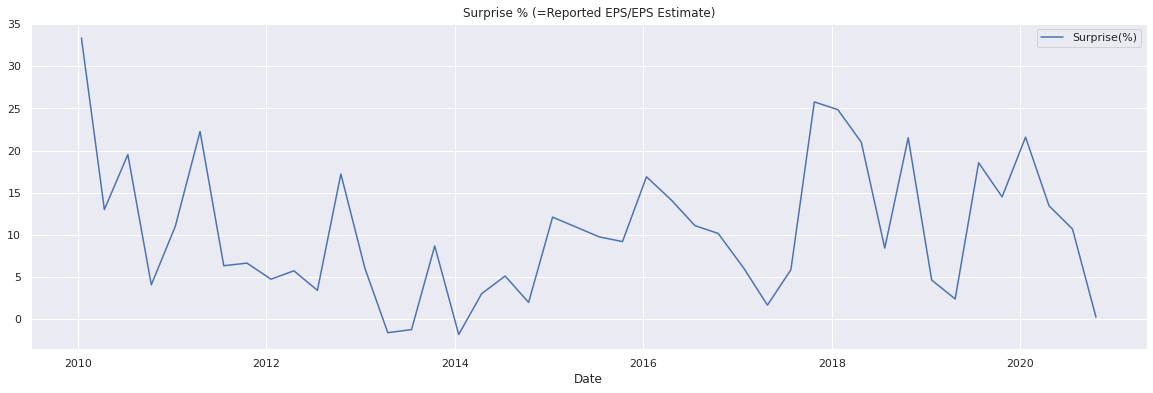

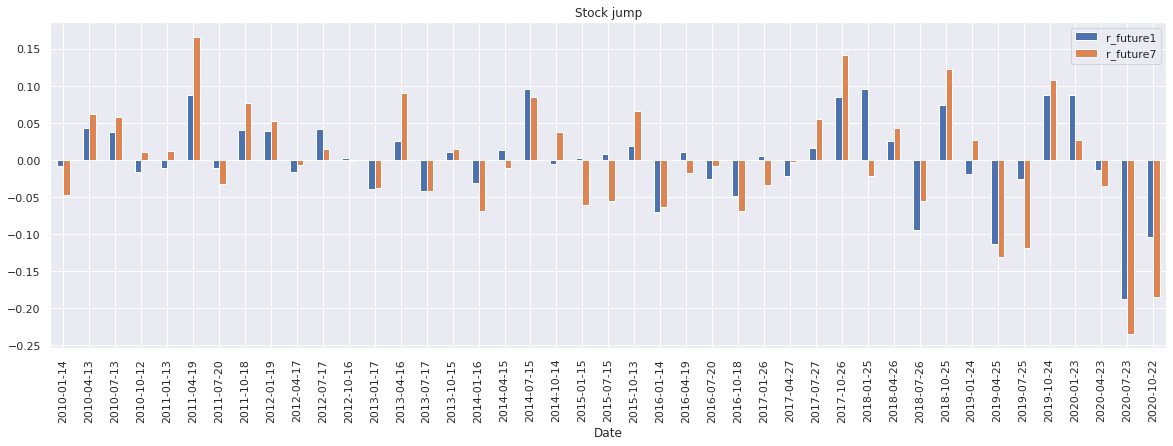

In [ ]:

# [[RESULT 4]] Individual stocks examples : Eps vs Eps_estimate, r1_future vs. r7_future
#    AAPL: interesting fact: if r1>0 then r7 is even higher ---> you simply need to buy if AAPL stock is rising just after the earnings
#    <many other stocks> - similar picture, but in 2020 - it is a 'bullish' market, when Q1-Q2-Q3 was growing quickly, especially for tech stocks
#  another idea: if stock dropped r1<0 , then in many cases r7 can be closer to 0 (you can still invest after drop waiting the stock to come back), but here results are inconclusive --> a lot of cases when it is not happenning
draw_plot("INTC")

     EPS Estimate  Reported EPS  Surprise(%)  r_future1  r_future7        Date
99           0.70          0.73         4.29  -0.021268   0.046738  2020-10-29
100          0.51          0.65        26.22   0.111591   0.172477  2020-07-30
101          0.56          0.64        12.92   0.004646   0.101439  2020-04-30
102          1.14          1.25         9.76   0.048613   0.051292  2020-01-28
103          0.71          0.76         6.76   0.022234   0.069964  2019-10-30
104          0.53          0.55         3.81   0.015898  -0.030260  2019-07-30
105          0.59          0.62         4.24   0.028475  -0.019195  2019-04-30
106          1.04          1.05         0.29   0.055682   0.089535  2019-01-29
107          0.70          0.73         4.60  -0.053397  -0.116215  2018-11-01
108          2.18          2.34         7.29   0.059239   0.095210  2018-07-31
109          2.67          2.73         2.13   0.066197   0.139715  2018-05-01
110          3.86          3.89         0.86  -0.042

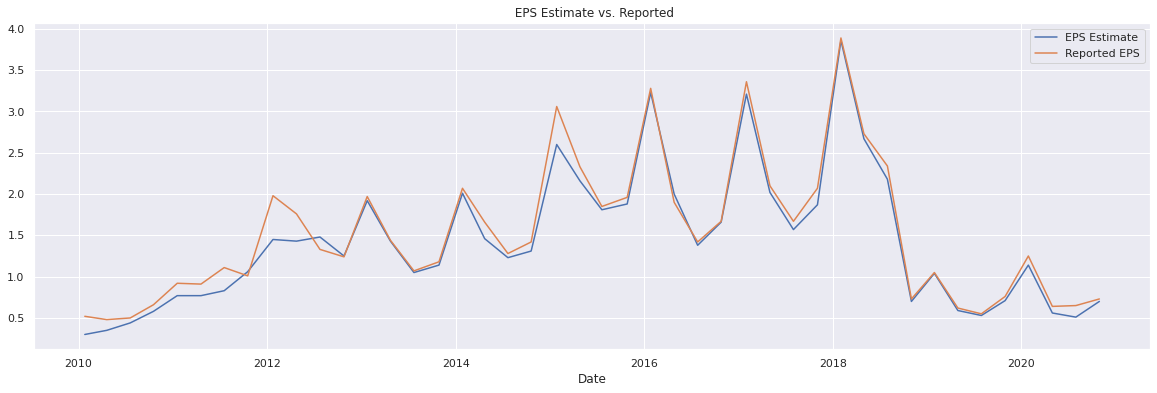

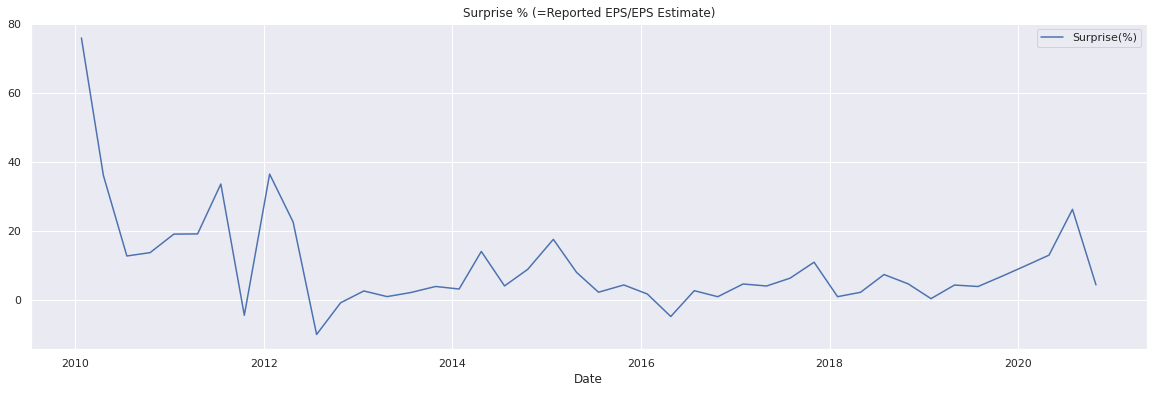

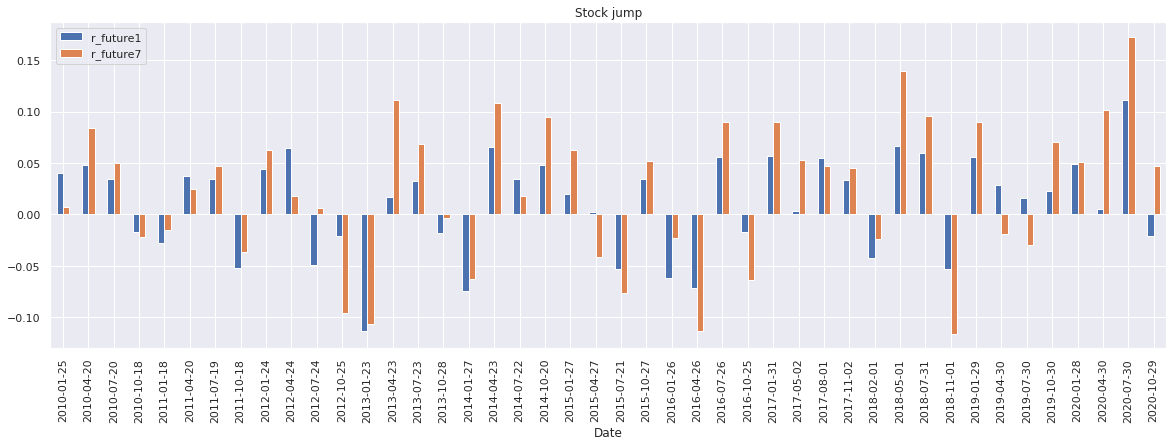

In [ ]:
draw_plot("AAPL")

      EPS Estimate  Reported EPS  Surprise(%)  r_future1  r_future7  \
1301         -0.05          0.01       120.00   0.241810   0.387392   
1302         -0.09         -0.09         1.10  -0.085466  -0.120111   
1303         -0.07         -0.08        -6.67   0.275025   0.309690   
1304          0.01          0.03       328.57  -0.118675  -0.035738   
1305         -0.05         -0.04        24.53  -0.100950   0.032392   
1306         -0.10         -0.06        40.00   0.218752   0.164496   
1307         -0.12         -0.10        15.25  -0.023696  -0.025473   
1308         -0.07         -0.04        45.95   0.214739   0.282256   
1309         -0.14         -0.12        13.67  -0.048183   0.045968   
1310         -0.17         -0.14        17.65  -0.064896  -0.069814   
1311         -0.17         -0.17        -1.80  -0.261736  -0.263551   
1312         -0.16         -0.13        18.24   0.404261   0.354868   
1313         -0.15         -0.14         7.28  -0.138650  -0.166135   
1314  

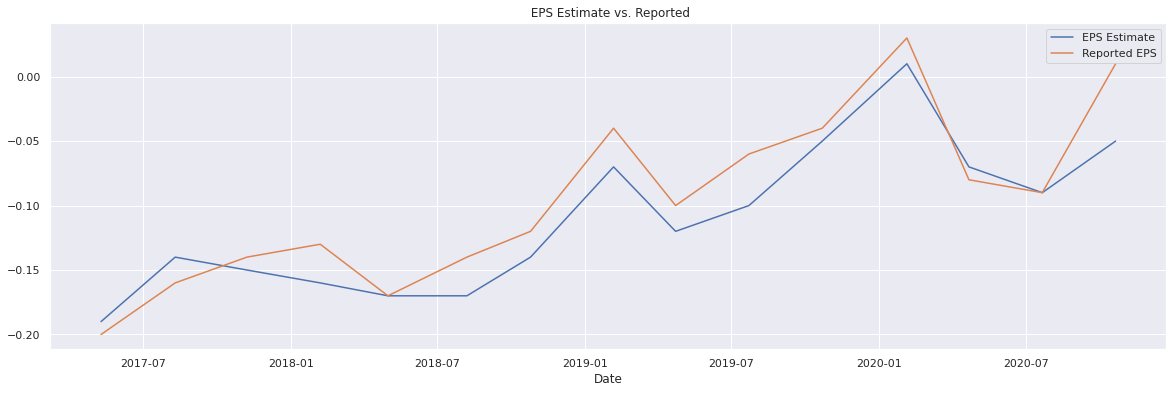

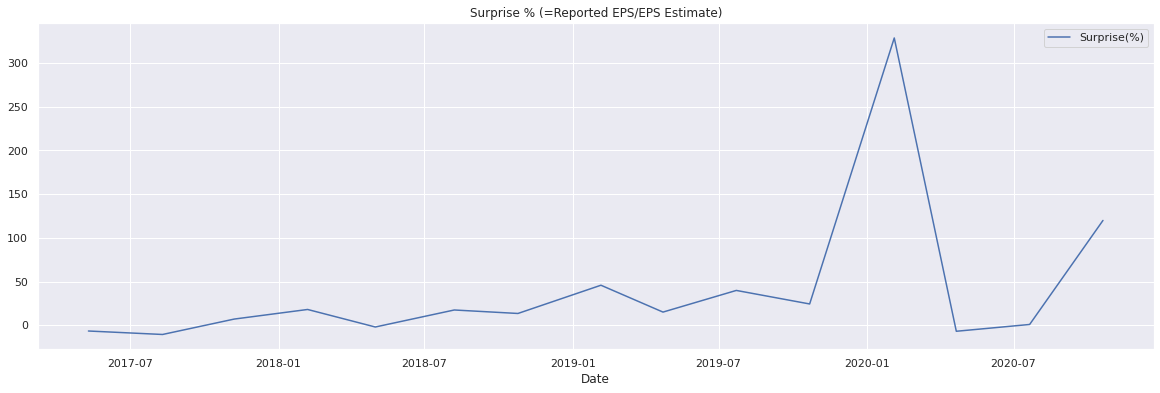

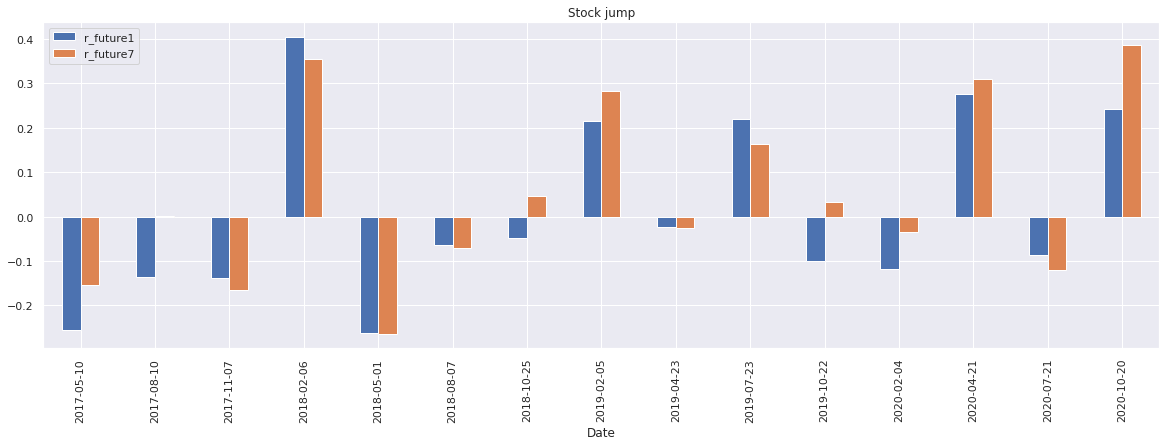

In [ ]:
# https://techcrunch.com/2020/10/20/snap-shares-explode-after-blowing-past-earnings-expectations/?utm_medium=TCnewsletter&tpcc=TCreviewnewsletter
# Shares going UP after successful report in Q3'20. --> BUT the data is not updated in Yahoo Finance EPS stats
draw_plot("SNAP")

    EPS Estimate  Reported EPS  Surprise(%)  r_future1  r_future7        Date
8          -0.04          0.06       246.34   0.037323   0.130534  2020-10-28
9          -0.10         -0.15       -48.51  -0.095891  -0.073773  2020-07-29
10          0.08          0.05       -36.71   0.000000  -0.077962  2020-04-29
11          0.18          0.21        17.98   0.081812   0.089637  2020-01-29
12          0.11          0.15        36.36   0.095611   0.239112  2019-10-30
13          0.12          0.17        44.07  -0.042725  -0.139524  2019-07-31
14          0.09          0.14        55.56   0.037322   0.031363  2019-04-30
15          0.22          0.17       -21.30   0.113132   0.097306  2019-01-31
16          0.20          0.14       -29.65  -0.099800  -0.204061  2018-10-30
17          0.18          0.19         7.95  -0.055403  -0.007310  2018-07-20
18          0.11          0.16        41.59   0.037184   0.004280  2018-04-20
19          0.29          0.27        -5.59  -0.042946  -0.07689

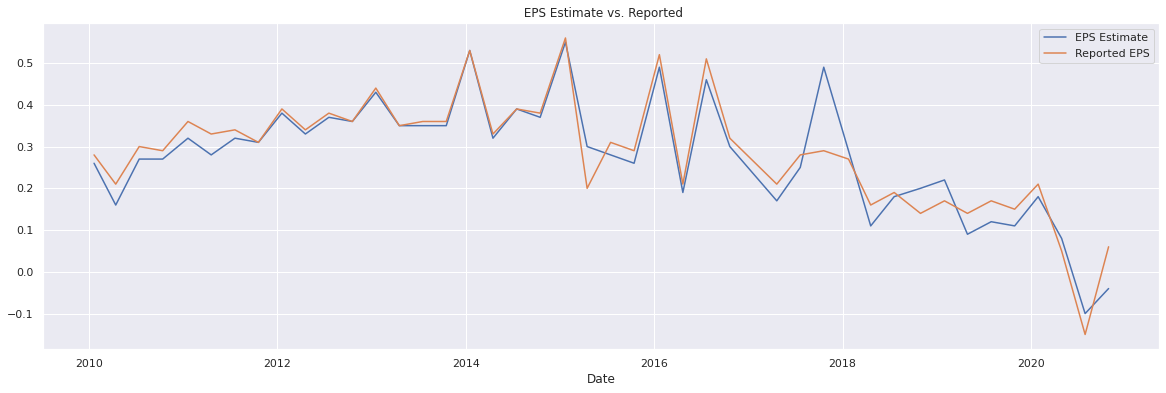

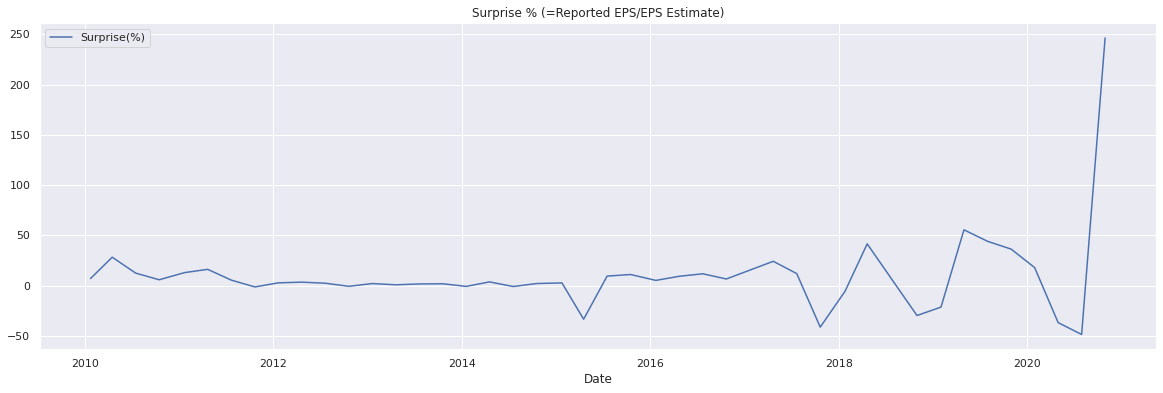

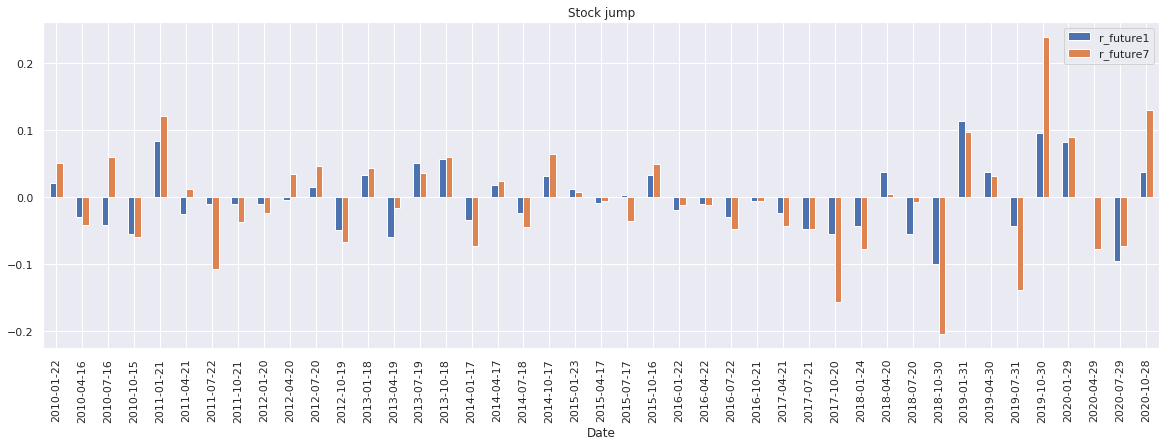

In [ ]:
draw_plot("GE")

     EPS Estimate  Reported EPS  Surprise(%)  r_future1  r_future7        Date
721          0.36          0.41        15.17  -0.073538   0.009320  2020-10-27
722          0.16          0.18         9.76   0.098245   0.228898  2020-07-28
723          0.31          0.32         4.23  -0.036172   0.001217  2020-01-28
724          0.18          0.18        -1.64  -0.016762   0.074066  2019-10-29
725          0.08          0.08         3.90  -0.094862   0.013057  2019-07-30
726          0.05          0.06        17.65  -0.032296  -0.017487  2019-04-30
727          0.08          0.08        -2.44   0.134708   0.116350  2019-01-29
728          0.12          0.13         4.84  -0.263920  -0.215303  2018-10-24
729          0.13          0.14        12.00   0.125236   0.132836  2018-07-25
730          0.09          0.11        23.60   0.089980   0.111486  2018-04-25
731          0.05          0.08        63.27   0.031045  -0.171569  2018-01-30
732          0.08          0.10        31.58  -0.134

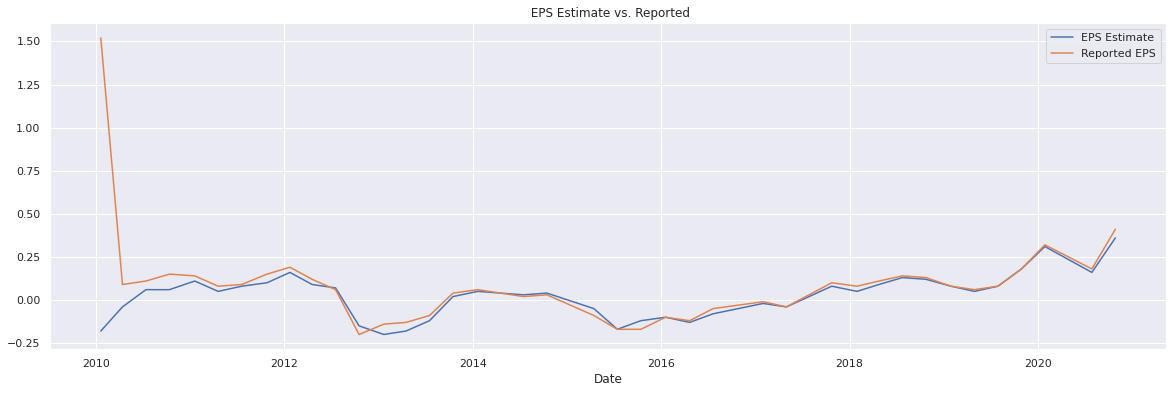

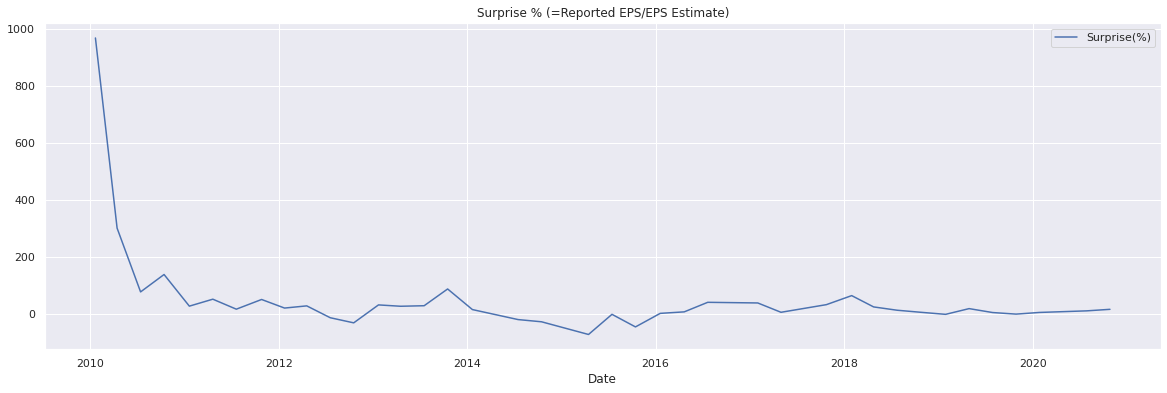

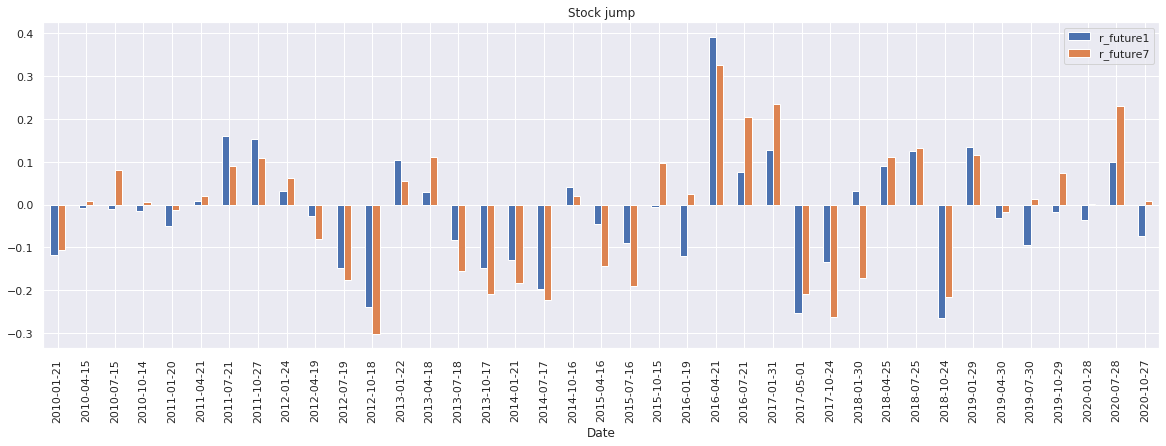

In [ ]:
draw_plot("AMD")

     EPS Estimate  Reported EPS  Surprise(%)  r_future1  r_future7        Date
534          0.49          0.51         3.45  -0.032589  -0.002006  2020-10-14
535          0.27          0.37        38.58  -0.057733  -0.018876  2020-07-16
536          0.46          0.40       -13.23  -0.102415  -0.067549  2020-04-15
537          0.68          0.74         8.19  -0.017134  -0.072498  2020-01-15
538          0.51          0.56        10.67   0.017670   0.064791  2019-10-16
539          0.71          0.74         4.67   0.016761   0.059589  2019-07-17
540          0.66          0.70         6.87   0.006347   0.016947  2019-04-16
541          0.63          0.70        10.94   0.087921   0.109758  2019-01-16
542          0.62          0.66         6.45   0.002457  -0.083122  2018-10-15
543          0.57          0.63        10.53   0.049874   0.084586  2018-07-16
544          0.59          0.62         4.73   0.008022   0.011345  2018-04-16
545          0.44          0.48         9.59   0.007

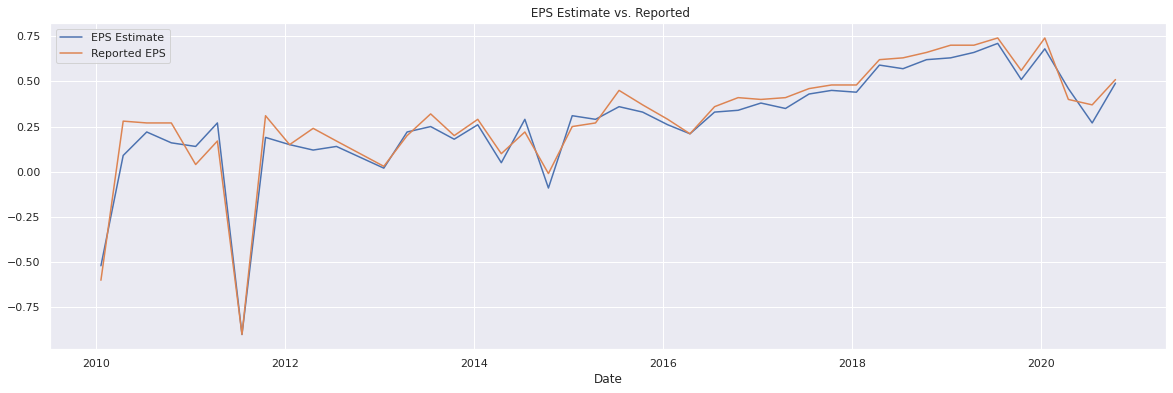

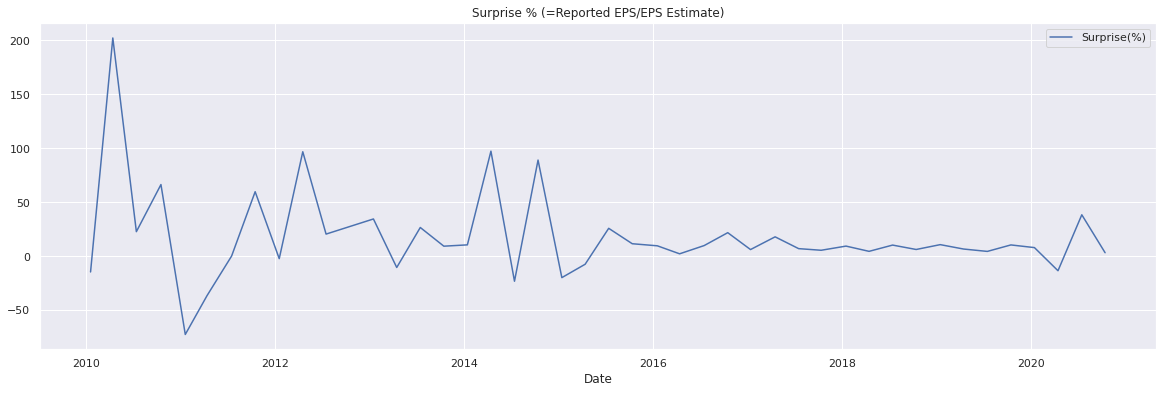

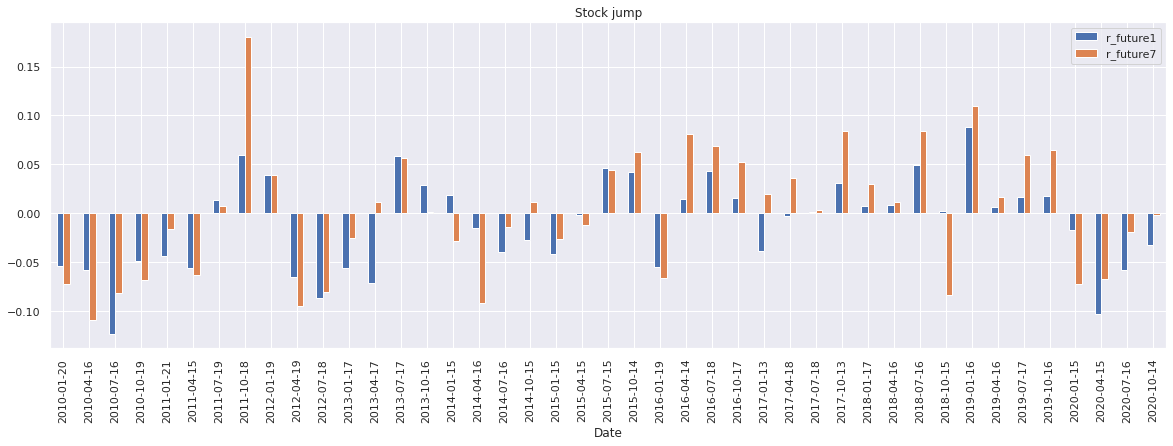

In [ ]:
draw_plot("BAC")

      EPS Estimate  Reported EPS  Surprise(%)  r_future1  r_future7  \
1935          1.54          1.82        17.88  -0.035860   0.060983   
1936          1.34          1.46         8.71  -0.030200  -0.018079   
1937          1.26          1.40        10.67   0.053878   0.083944   
1938          1.32          1.51        14.48   0.043290   0.105608   
1939          1.25          1.38        10.84   0.025842   0.052495   
1940          1.21          1.37        12.94   0.002565   0.034334   
1941          1.00          1.14        14.11   0.029147   0.027209   
1942          1.09          1.10         0.73   0.014371   0.026175   
1943          0.96          1.14        18.38   0.001848  -0.018109   
1944          1.08          1.13         5.02   0.010880   0.002375   
1945          0.85          0.95        11.90   0.037319   0.041485   
1946          0.87          0.96        10.98   0.016257  -0.050420   
1947          0.72          0.84        16.50   0.063799   0.071643   
1948  

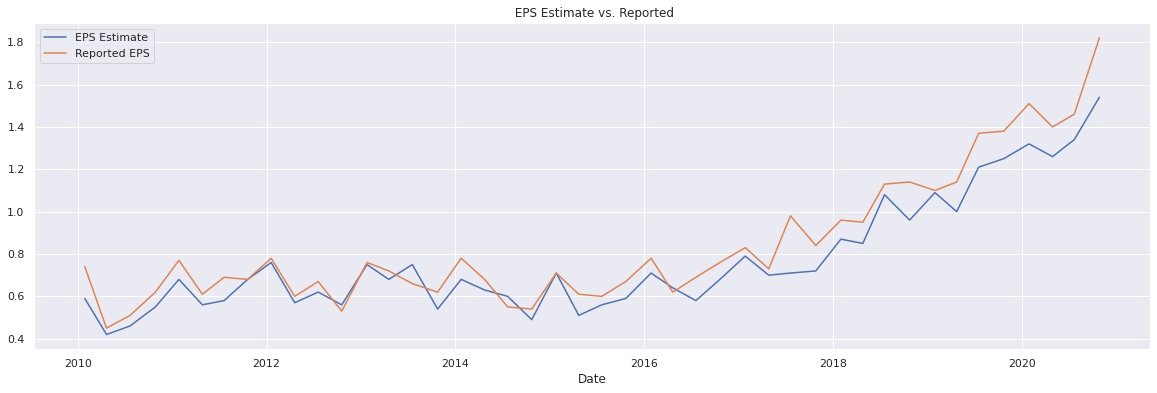

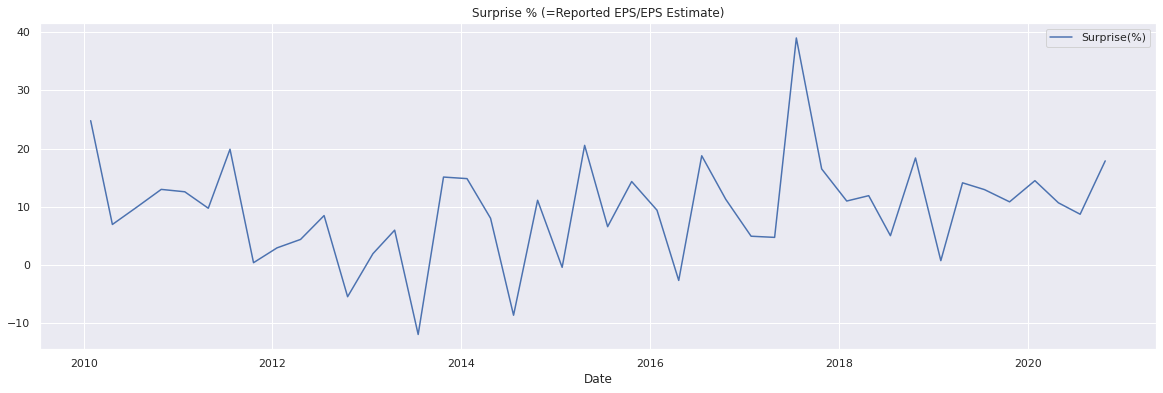

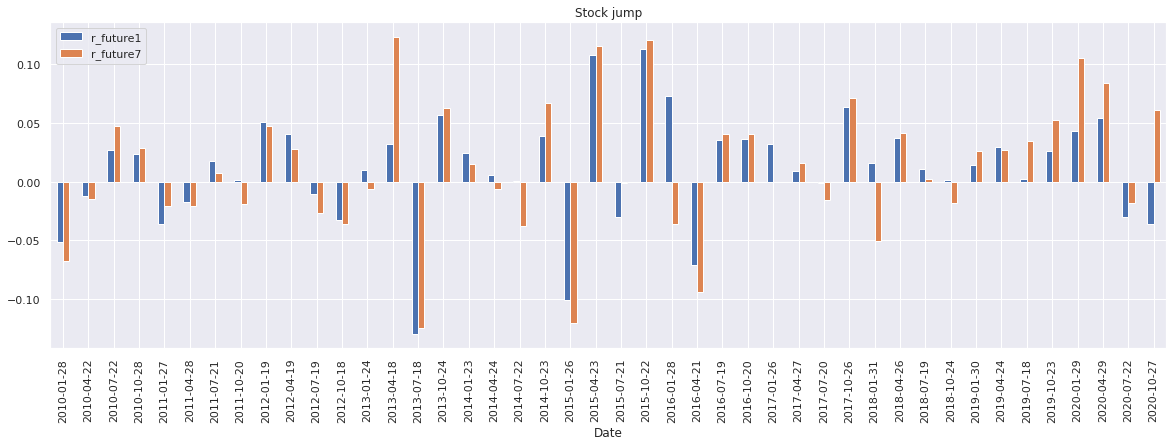

In [ ]:
draw_plot("MSFT")

     EPS Estimate  Reported EPS  Surprise(%)  r_future1  r_future7        Date
937          0.59          0.76        29.03   0.009083  -0.083755  2020-10-21
938         -0.03          0.44      1776.92  -0.035890  -0.091825  2020-07-22
939         -0.05          0.23       547.06   0.016454   0.063350  2020-04-29
940          0.35          0.41        19.42   0.122550   0.277314  2020-01-29
941         -0.08          0.37       542.86   0.159180   0.203658  2019-10-23
942         -0.07         -0.22      -215.49  -0.128400  -0.104562  2019-07-24
943         -0.14         -0.58      -323.36  -0.063635  -0.034189  2019-04-24
944          0.44          0.39       -12.27   0.031633   0.027652  2019-01-30
945         -0.04          0.58      1587.18   0.068072   0.163567  2018-10-24
946         -2.92         -3.06        -4.69   0.159055   0.175934  2018-08-01
947         -3.58         -3.35         6.48  -0.052958   0.003794  2018-05-02
948         -3.09         -3.04         1.68  -0.057

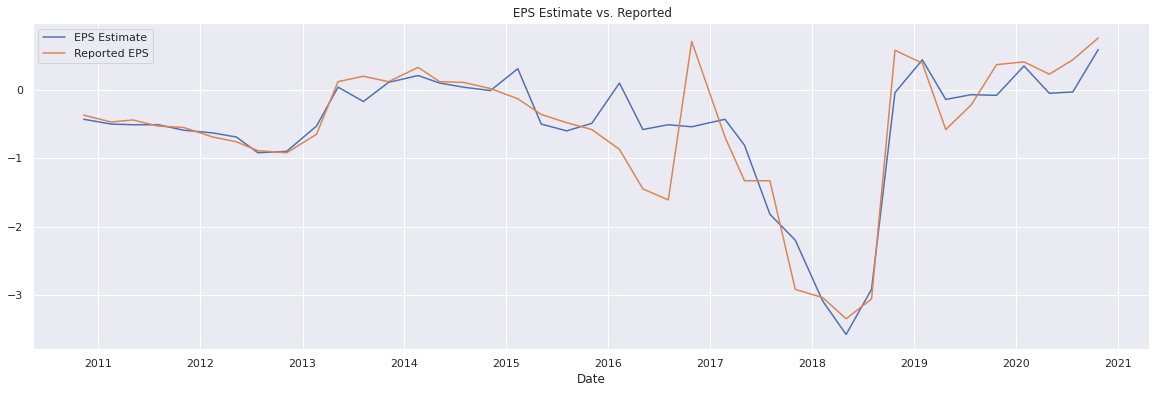

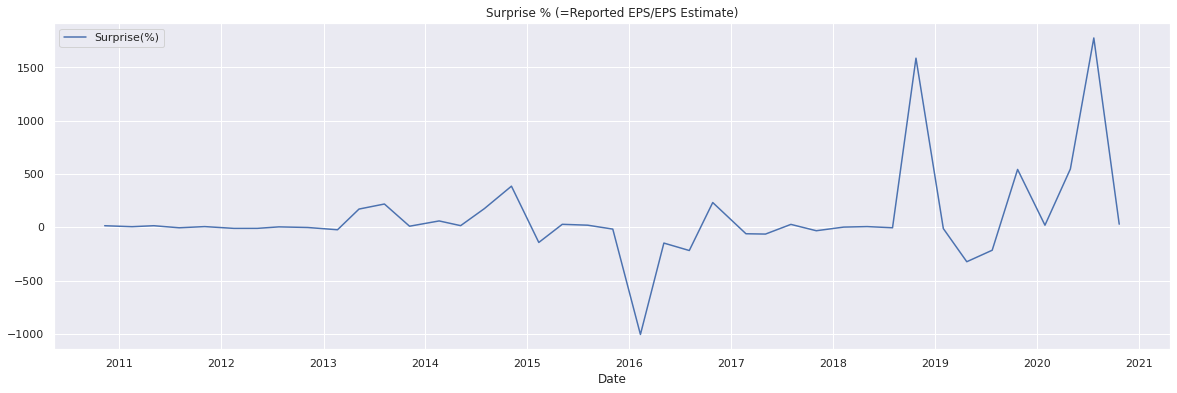

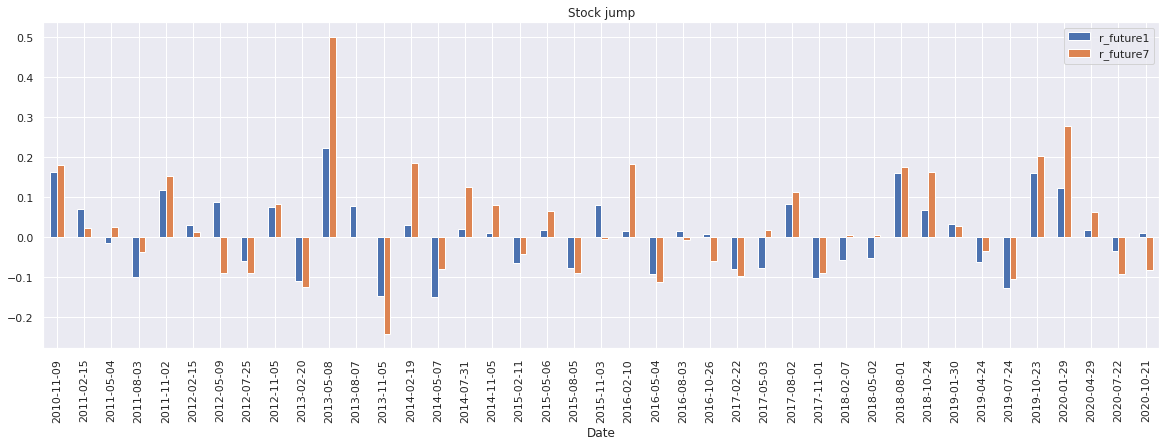

In [ ]:
draw_plot("TSLA")

      EPS Estimate  Reported EPS  Surprise(%)  r_future1  r_future7  \
3556          1.91          2.71        42.18  -0.017183   0.040632   
3557          1.39          1.80        29.59   0.083752   0.119872   
3558          1.76          1.71        -2.56   0.112600   0.149242   
3559          2.53          2.56         1.35  -0.038664  -0.025390   
3560          1.91          2.12        10.94   0.012285   0.008049   
3561          1.88          0.91       -51.62  -0.008187  -0.068195   
3562          1.63          0.85       -47.72   0.050297   0.061668   
3563          2.19          2.38         8.87   0.145004   0.148836   
3564          1.47          1.76        19.65   0.066037   0.039873   
3565          1.72          1.74         1.10  -0.197142  -0.188555   
3566          1.35          1.69        25.09   0.086740   0.100709   
3567          1.95          1.44       -26.23   0.031406  -0.060641   
3568          1.28          1.59        24.12  -0.006351  -0.008926   
3569  

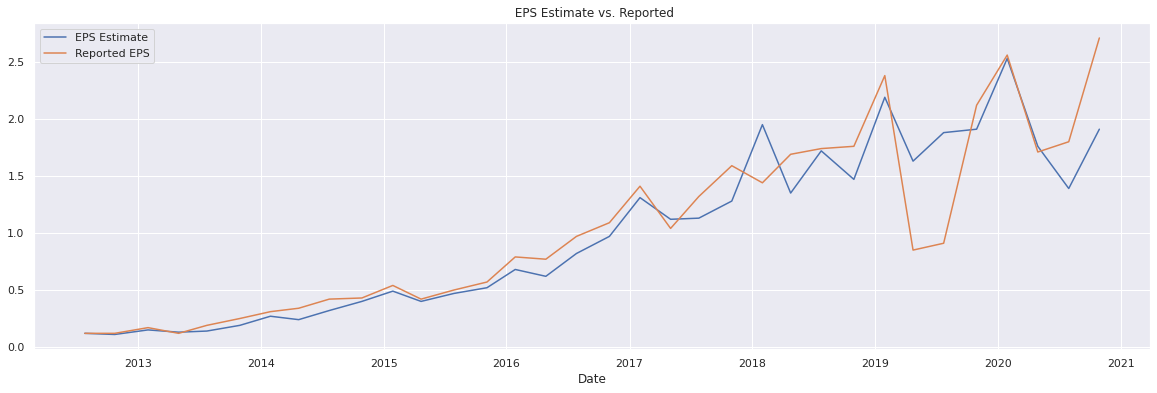

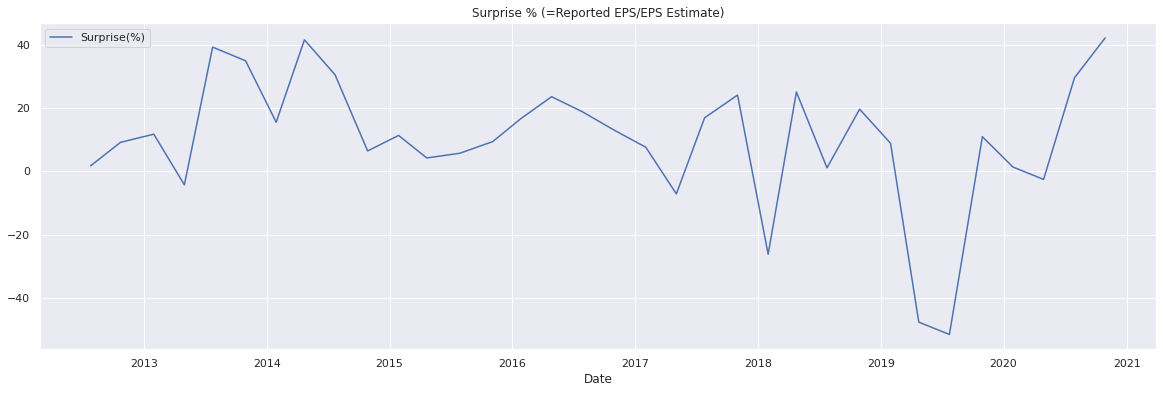

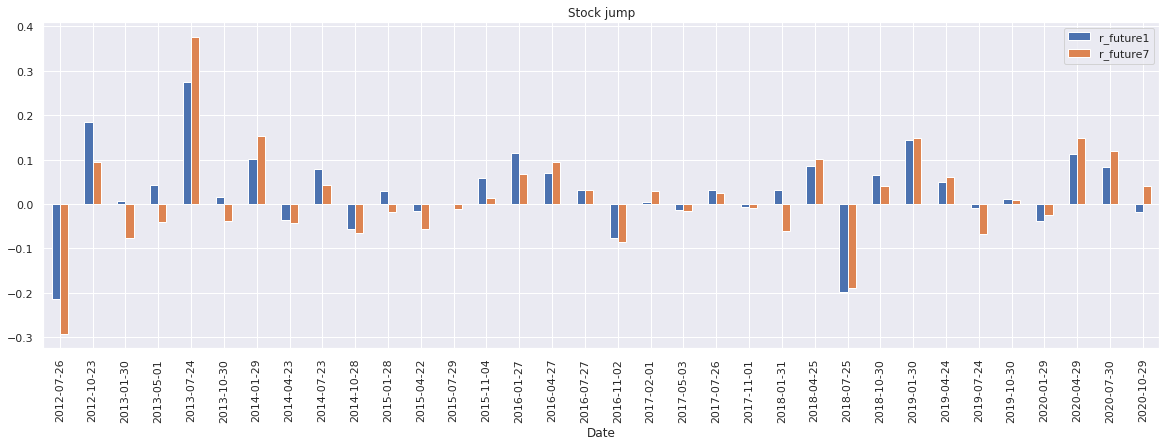

In [ ]:
draw_plot("FB")

       EPS Estimate  Reported EPS  Surprise(%)  r_future1  r_future7  \
12139         11.21         16.40        46.31   0.066565   0.150533   
12140          8.34         10.13        21.43  -0.025998  -0.017177   
12141         10.38          9.87        -4.91   0.050137   0.073042   
12142         12.59         15.35        21.96   0.008913   0.056943   
12143         12.46         10.12       -18.75  -0.001986   0.020862   
12144         11.33         14.21        25.39   0.094366   0.012672   
12145         10.63          9.50       -10.63  -0.068057  -0.086921   
12146         10.82         12.77        18.00   0.031233   0.008436   
12147         10.40         13.06        25.58   0.019565  -0.010159   
12148          9.54          4.54       -52.40   0.051939   0.029192   
12149          9.32         13.33        43.06  -0.050638  -0.046334   
12150          9.96          9.70        -2.63  -0.050882  -0.106316   
12151          8.33          9.57        14.90   0.046119   0.05

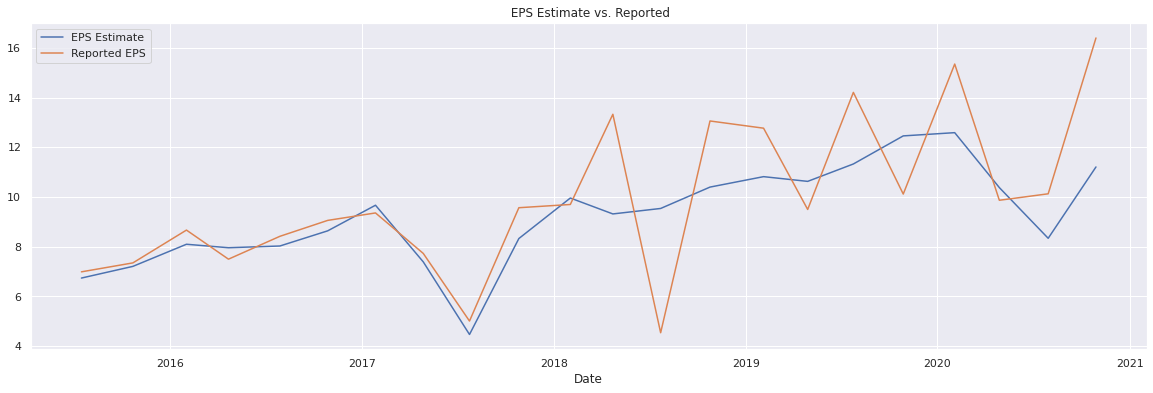

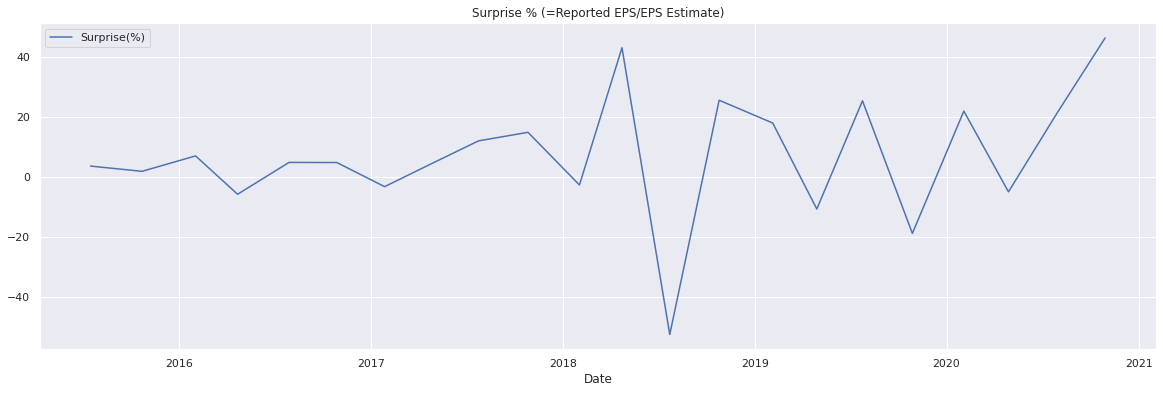

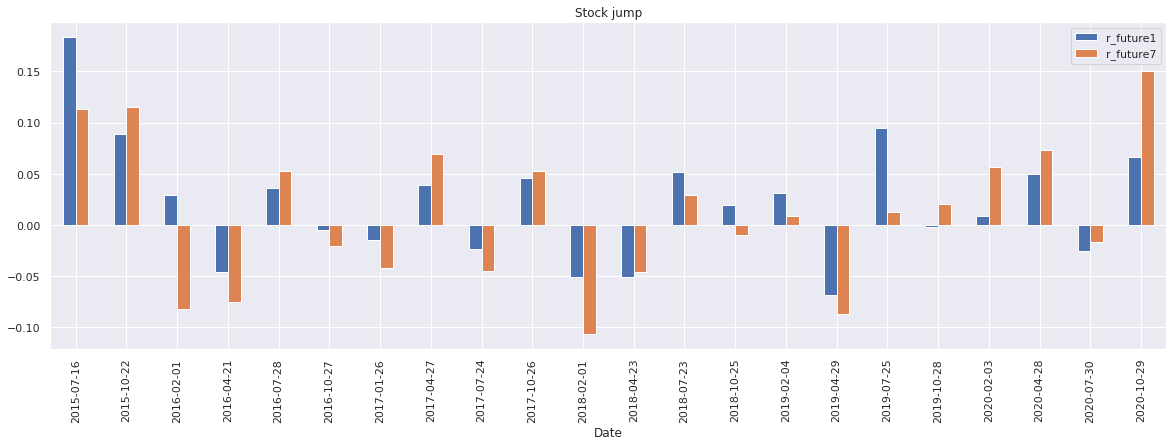

In [ ]:
draw_plot("GOOG")

     EPS Estimate  Reported EPS  Surprise(%)  r_future1  r_future7        Date
534          0.49          0.51         3.45  -0.032589  -0.002006  2020-10-14
535          0.27          0.37        38.58  -0.057733  -0.018876  2020-07-16
536          0.46          0.40       -13.23  -0.102415  -0.067549  2020-04-15
537          0.68          0.74         8.19  -0.017134  -0.072498  2020-01-15
538          0.51          0.56        10.67   0.017670   0.064791  2019-10-16
539          0.71          0.74         4.67   0.016761   0.059589  2019-07-17
540          0.66          0.70         6.87   0.006347   0.016947  2019-04-16
541          0.63          0.70        10.94   0.087921   0.109758  2019-01-16
542          0.62          0.66         6.45   0.002457  -0.083122  2018-10-15
543          0.57          0.63        10.53   0.049874   0.084586  2018-07-16
544          0.59          0.62         4.73   0.008022   0.011345  2018-04-16
545          0.44          0.48         9.59   0.007

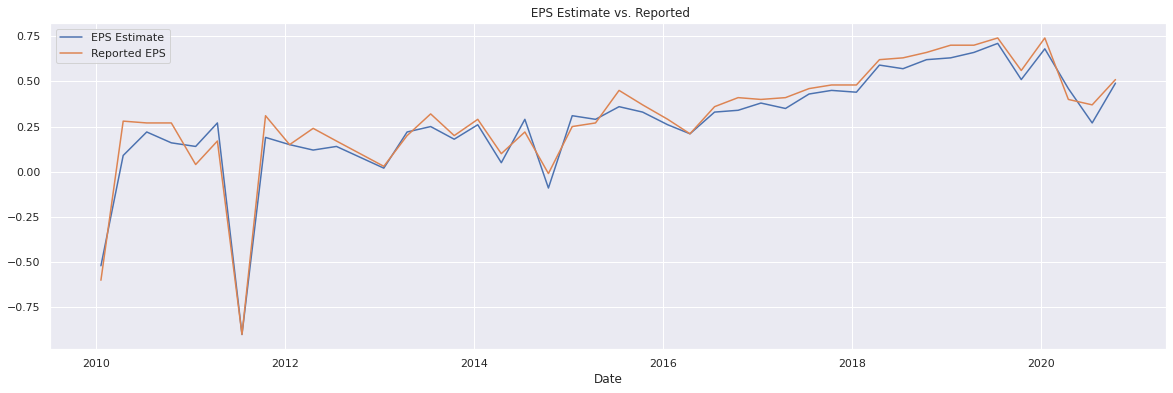

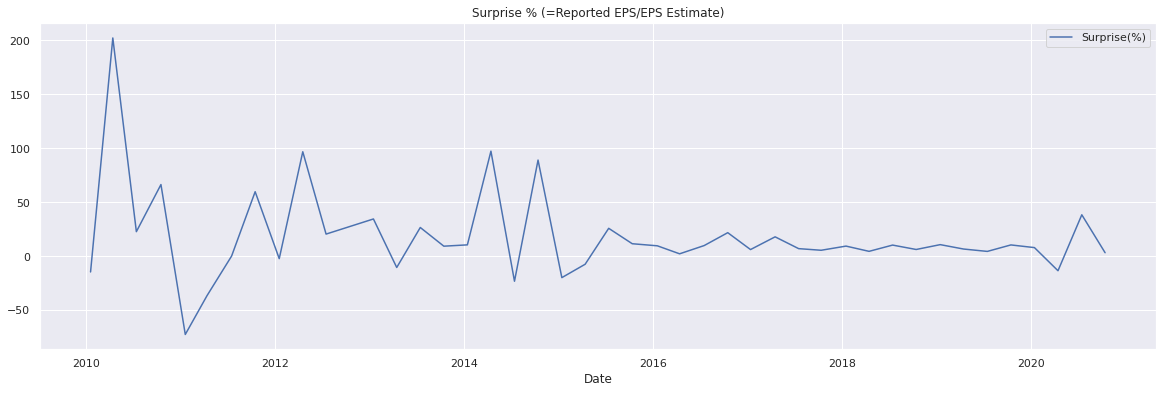

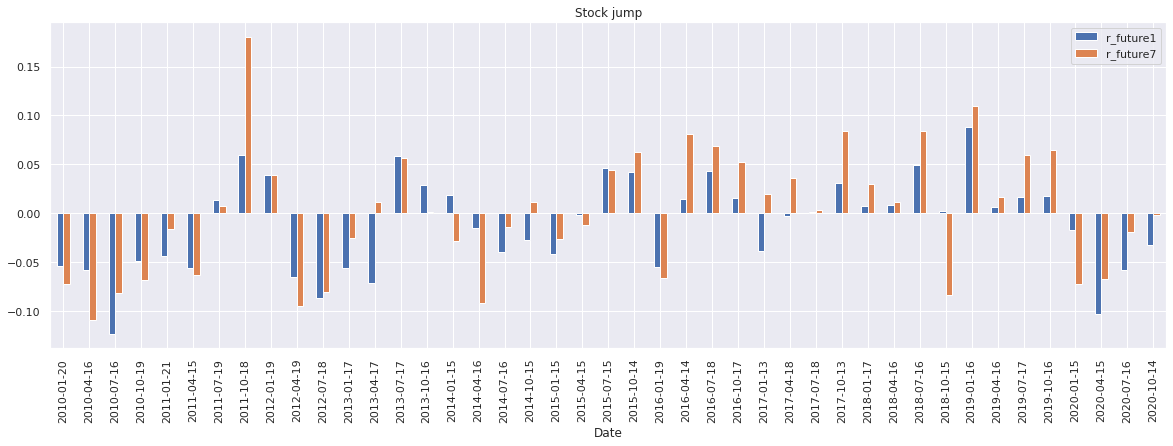

In [ ]:
draw_plot("BAC")

     EPS Estimate  Reported EPS  Surprise(%)  r_future1  r_future7        Date
346          0.19          0.65       238.54  -0.002528  -0.016550  2020-10-28
347         -1.17         -0.35        70.19  -0.045832   0.024270  2020-07-30
348         -0.12         -0.23       -88.52   0.017258  -0.059779  2020-04-28
349          0.15          0.12       -20.53  -0.077540  -0.084787  2020-02-04
350          0.26          0.34        30.77  -0.053210  -0.020045  2019-10-23
351          0.31          0.28        -8.50  -0.061854  -0.091581  2019-07-24
352          0.27          0.44        65.41   0.084134   0.080284  2019-04-25
353          0.32          0.30        -4.76   0.011696   0.042825  2019-01-23
354          0.28          0.29         4.32   0.045514   0.087981  2018-10-24
355          0.31          0.27       -13.46  -0.066496  -0.051443  2018-07-25
356          0.41          0.43         4.88   0.041989   0.035846  2018-04-25
357          0.42          0.39        -6.70  -0.033

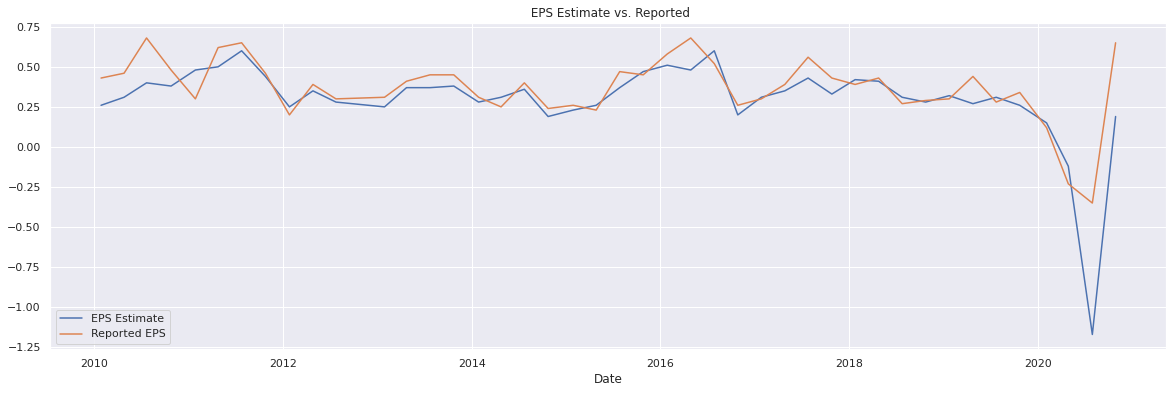

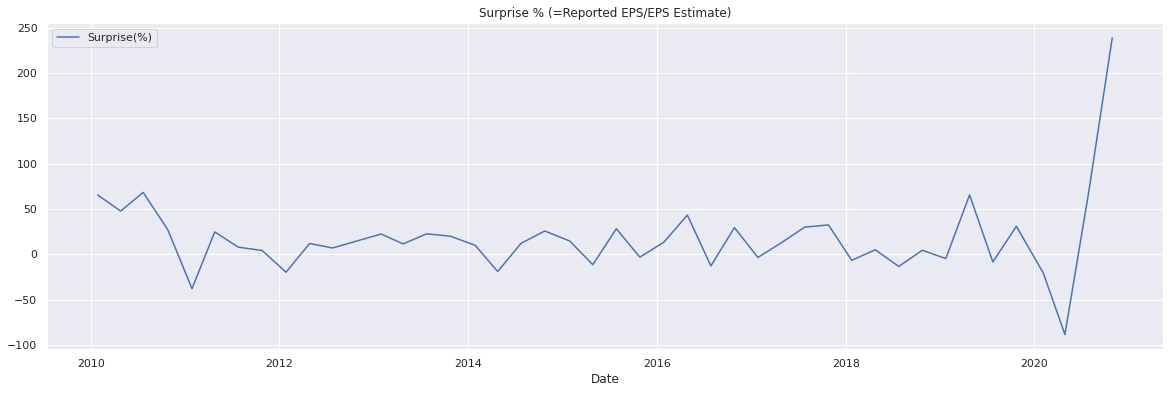

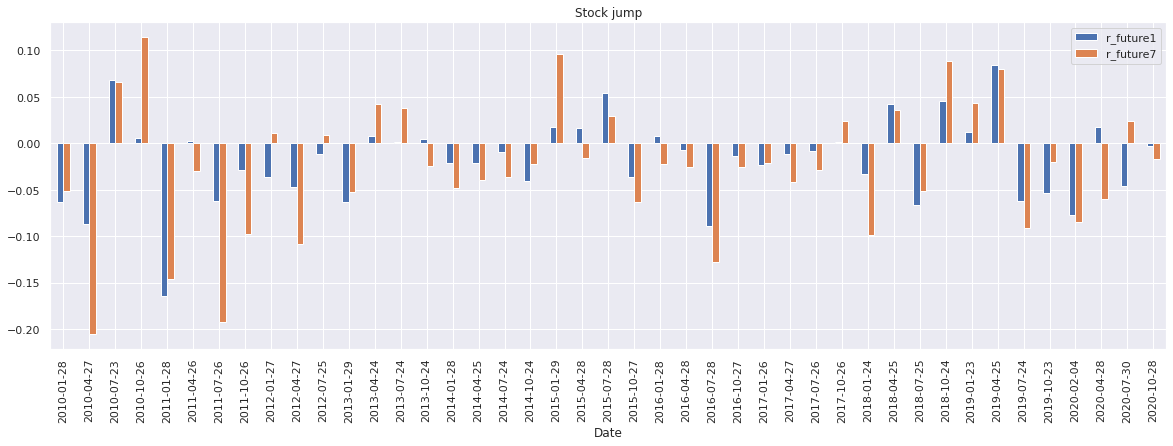

In [ ]:
draw_plot("F")

       EPS Estimate  Reported EPS  Surprise(%)  r_future1  r_future7  \
10855          0.65          0.71         9.74  -0.042400  -0.046635   
10856          0.69          0.97        41.61  -0.005559  -0.042155   
10857          0.38          0.58        53.44   0.088472   0.089706   
10858          1.19          1.23         3.36   0.044533   0.079821   
10859          0.23          0.32        37.34  -0.037236  -0.066575   
10860          0.26          0.38        46.72  -0.000832  -0.003749   
10861          0.25          0.31        25.00  -0.029466  -0.112110   
10862          1.28          1.29         0.55   0.105435   0.034068   
10863          0.50          0.52         4.00  -0.168256  -0.281098   
10864          0.35          0.41        16.48  -0.024378  -0.035658   
10865          0.35          0.38         9.83   0.020980   0.047264   
10866          0.93          0.94         1.29  -0.034865   0.019673   
10867          0.49          0.60        21.46  -0.033147  -0.02

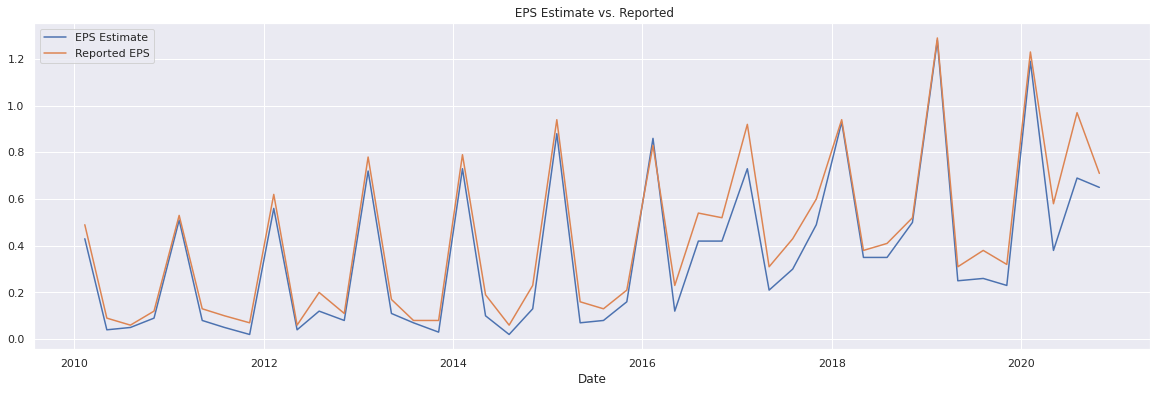

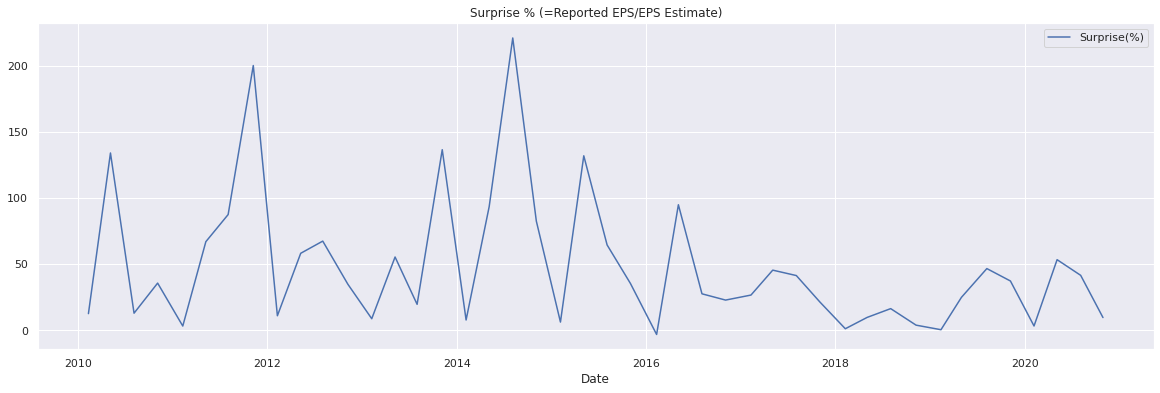

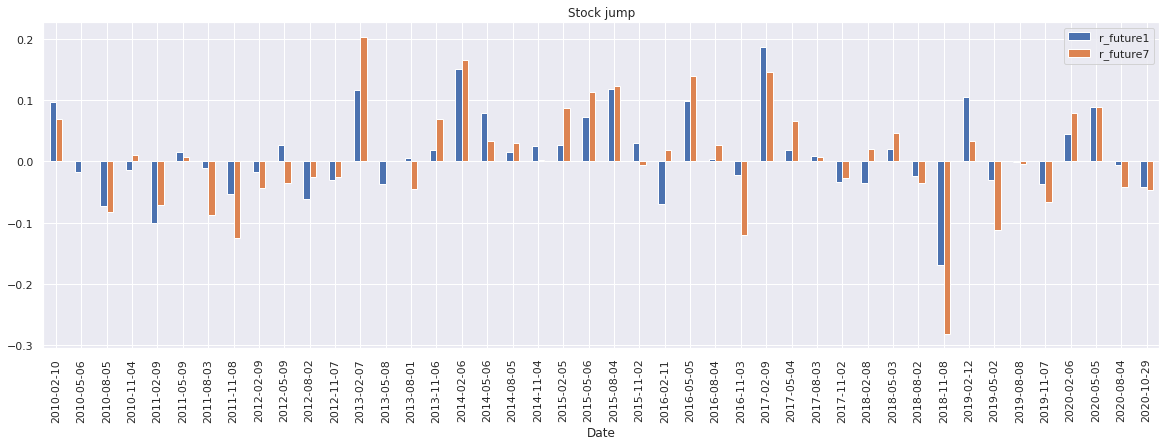

In [ ]:
draw_plot("ATVI")

In [ ]:
# filter1 = df_stocks_prices.Ticker=='INTC' 
filter1 = df_stocks_prices.Ticker=='SAP' 
filter2 = df_stocks_prices.Year == 2020
filter3 = df_stocks_prices.Month == 7
df_stocks_prices[filter1 & filter2 & filter3].tail(10)

Open        High  ...  ln_volume              PK
1231395  157.690002  159.899994  ...  13.105421  SAP|2020-07-20
1231396  163.000000  163.940002  ...  13.484643  SAP|2020-07-21
1231397  164.860001  165.279999  ...  13.461546  SAP|2020-07-22
1231398  163.669998  164.630005  ...  13.433811  SAP|2020-07-23
1231399  157.460007  159.029999  ...  13.699426  SAP|2020-07-24
1231400  162.279999  165.389999  ...  13.971403  SAP|2020-07-27
1231401  161.820007  162.139999  ...  13.298164  SAP|2020-07-28
1231402  163.839996  165.429993  ...  13.037459  SAP|2020-07-29
1231403  158.160004  160.550003  ...  13.580168  SAP|2020-07-30
1231404  160.669998  160.759995  ...  13.460263  SAP|2020-07-31

[10 rows x 25 columns]

In [ ]:
# EXAMPLE: 26-Oct-2020 
  # https://www.marketbeat.com/stocks/NYSE/SAP/earnings/ -- stocks EPS vs. Actuals
# https://markets.businessinsider.com/news/stocks/sap-stock-price-2020-outlook-downgrade-2020-10-1029720099#
# https://news.sap.com/2020/10/sap-announces-third-quarter-and-first-nine-months-2020-results/

# Despite good EPS and their growth - stock price crashed

# filter3 = merged_df.Symbol == "INTC"
filter3 = merged_df.Symbol == "SAP"

merged_df[filter3].head(20)

Symbol Company  ... years_from_now  ln_volume
12161    SAP  SAP SE  ...              0  13.971403
12162    SAP  SAP SE  ...              0  14.329232
12163    SAP  SAP SE  ...              0  14.598864
12164    SAP  SAP SE  ...              1  14.006544
12165    SAP  SAP SE  ...              1  14.961897
12166    SAP  SAP SE  ...              1  15.361817
12167    SAP  SAP SE  ...              1  14.532618
12168    SAP  SAP SE  ...              2  14.729037
12169    SAP  SAP SE  ...              2  14.145174
12170    SAP  SAP SE  ...              2  14.925689
12171    SAP  SAP SE  ...              2  15.631279
12172    SAP  SAP SE  ...              3  14.403075
12173    SAP  SAP SE  ...              3  13.986434
12174    SAP  SAP SE  ...              3  14.206742
12175    SAP  SAP SE  ...              3  13.987529
12176    SAP  SAP SE  ...              4  14.943423
12177    SAP  SAP SE  ...              4  14.881978
12178    SAP  SAP SE  ...              4  14.511055
12179    SAP  SAP SE  ...              4  14.636743
12180    SAP  SAP SE  ...              5  15.055738

[20 rows x 32 columns]

In [ ]:
# All Quarterly reports in Oct from top 150 trading stocks
filter1 = merged_df.Year == 2020
filter2  =  merged_df.Month == 10
# filter3 = merged_df.Symbol = 'SAP'
merged_df[filter1 & filter2].head(30)

Symbol                         Company  ... years_from_now  ln_volume
8        GE        General Electric Company  ...              0  19.350851
99     AAPL                      Apple Inc.  ...              0  18.800002
189     PFE                     Pfizer Inc.  ...              0  17.422407
285     AAL     American Airlines Group Inc  ...              0  18.324048
346       F              Ford Motor Company  ...              0  18.233608
440     CCL      Carnival Corporation & Plc  ...              0  17.528741
534     BAC     Bank of America Corporation  ...              0  18.664124
629     WFC           Wells Fargo & Company  ...              0  18.139614
721     AMD    Advanced Micro Devices, Inc.  ...              0  18.869649
937    TSLA                     Tesla, Inc.  ...              0  17.292758
1204    NOK               Nokia Corporation  ...              0  18.820349
1301   SNAP                       Snap Inc.  ...              0  17.667102
1316      T                       AT&T Inc.  ...              0  18.309837
1648   INTC               Intel Corporation  ...              0  17.541751
1935   MSFT           Microsoft Corporation  ...              0  17.418295
2149    KMI             Kinder Morgan, Inc.  ...              0  16.497894
2188    FCX           Freeport-McMoRan Inc.  ...              0  16.876056
2380  CMCSA             Comcast Corporation  ...              0  16.828808
2633     BA              The Boeing Company  ...              0  16.825136
2729    PCG                PG&E Corporation  ...              0  16.213551
2824   FEYE                   FireEye, Inc.  ...              0  15.411519
2852   VALE                       Vale S.A.  ...              0  17.105169
2938   TWTR                   Twitter, Inc.  ...              0  17.839712
3007   ABEV                      Ambev S.A.  ...              0  17.383321
3032    XOM         Exxon Mobil Corporation  ...              0  17.684327
3225   SIRI         Sirius XM Holdings Inc.  ...              0  17.262669
3303      C                  Citigroup Inc.  ...              0  17.725514
3393    BSX   Boston Scientific Corporation  ...              0  16.703502
3489   MRNA                   Moderna, Inc.  ...              0  16.438468
3497    UAL  United Airlines Holdings, Inc.  ...              0  16.527845

[30 rows x 32 columns]

# 6) Scaled Analysis 
  Get some examples for the individual stocks - history  <br>
  Short-term effect <br>
  Clustering high returns <br>
  Outliers clusters <br>
  Next planned dates for Q3 <br> 

**INVEST IDEA/HYPOTHESIS\:** If stocks goes up in day1 after the report -> it will go up for several days. The same is true if stock goes down ?

In [ ]:
merged_df.describe().transpose()

count          mean  ...           75%           max
EPS Estimate    12252.0  5.426583e-01  ...  7.100000e-01  3.242000e+01
Reported EPS    12252.0  5.226379e-01  ...  7.500000e-01  3.540000e+01
Surprise(%)     12252.0  9.852612e-01  ...  1.346000e+01  6.900000e+03
Open            12252.0  3.339083e+01  ...  3.550212e+01  1.522360e+03
High            12252.0  3.399888e+01  ...  3.624999e+01  1.593710e+03
Low             12252.0  3.270125e+01  ...  3.479747e+01  1.522240e+03
Close           12252.0  3.335448e+01  ...  3.553325e+01  1.567240e+03
Volume          12252.0  2.452126e+07  ...  2.202490e+07  2.434754e+09
Dividends       12252.0  2.165064e-03  ...  0.000000e+00  1.254000e+00
Stock Splits    12252.0  2.120470e-04  ...  0.000000e+00  1.500000e+00
Year            12252.0  2.009786e+03  ...  2.016000e+03  2.020000e+03
Month           12252.0  6.063500e+00  ...  1.000000e+01  1.200000e+01
Weekday         12252.0  2.034443e+00  ...  3.000000e+00  4.000000e+00
r_future1       12252.0  4.157350e-04  ...  3.454409e-02  8.896768e-01
r_future2       12249.0  1.368845e-05  ...  3.786464e-02  1.091855e+00
r_future3       12241.0 -1.933405e-04  ...  4.021830e-02  1.433159e+00
r_future4       12239.0  1.771551e-04  ...  4.339024e-02  1.233826e+00
r_future5       12235.0  6.560422e-04  ...  4.501706e-02  1.056053e+00
r_future6       12232.0  1.020367e-03  ...  4.676177e-02  9.500573e-01
r_future7       12223.0  1.293883e-03  ...  4.870708e-02  9.808293e-01
r_future30      12078.0  3.371336e-03  ...  8.306072e-02  1.391960e+00
r_future90      11905.0  1.667985e-02  ...  1.488982e-01  2.527908e+00
r_future365     11171.0  7.639161e-02  ...  3.552814e-01  3.151211e+00
years_from_now  12252.0  1.021368e+01  ...  1.600000e+01  2.700000e+01
ln_volume       12252.0  1.603834e+01  ...  1.690768e+01  2.161311e+01

[25 rows x 8 columns]

## 6.1) Draw one example of a graph and make function from it (parameterize the group_by and filter values
 **IDEA:** We want to find a cluster when r7 is consistently higher than r1 --> we can buy at the day of report and sell at r7

Count observations:  Year
1993      8
1994      8
1995     19
1996     62
1997    330
1998    365
1999    372
2000    390
2001    395
2002    413
2003    427
2004    439
2005    444
2006    484
2007    499
2008    506
2009    500
2010    512
2011    523
2012    534
2013    567
2014    577
2015    603
2016    612
2017    612
2018    638
2019    697
2020    716
Name: r_future1, dtype: int64


Text(0.5, 1.0, '1 and 7 days returns of stocks after the quarterly earnings results announcement')

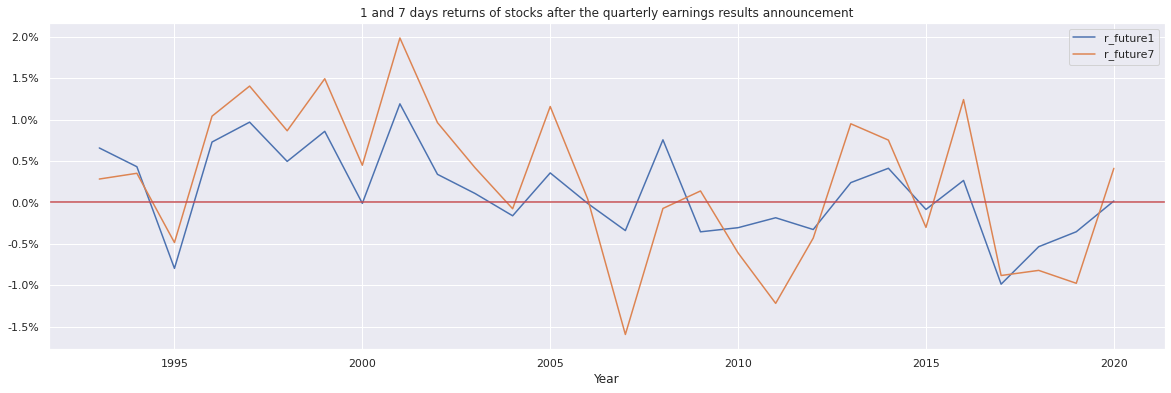

In [ ]:
# [[RESULT 5]] "Scaled analysis": we try to find a segment of stocks, where we can predict that r7_future > r1_future (buy at day1 and sell at day 7 after the earnings day)


# [[RESULT 5-1]] One example of r1-r7 returns split by years (averaged accross stocks)
#    In 2020 it is around 0% on average and r7 is slightly higher than r1 (it is good -> if you invest in many stocks - you will have a slight positive return in 2020, but it may not continue in this quarter)
# ONE EXAMPLE:

import matplotlib.pyplot as plt

print('Count observations: ',merged_df.groupby(by='Year').count()['r_future1'])

ax = merged_df.groupby(by='Year').mean()[['r_future1','r_future7']].plot.line(figsize=(20,6))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
plt.axhline(y=0, color='r', linestyle='-')
plt.title("1 and 7 days returns of stocks after the quarterly earnings results announcement")


In [ ]:


# [[Tech 6]] We create a parametrised version of a previous graph - you can select a feature for groupby, and condition to filter

# make the same graph but for different groupby and filter factors
  # it is too few observations when Year<=2000 --> let's cut it anyway

# Always have integer Year values: https://stackoverflow.com/questions/30914462/matplotlib-how-to-force-integer-tick-labels  
from matplotlib.ticker import MaxNLocator


def draw_returns(groupby_factor, filter):
  filter_year = merged_df.Year>=2000
  print('Count observations: ',merged_df[filter & filter_year].groupby(by=groupby_factor).count()['r_future1'])
  ax = merged_df[filter & filter_year].groupby(by=groupby_factor).mean()[['r_future1','r_future7']].plot.line(figsize=(20,6))
  vals = ax.get_yticks()
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
  plt.axhline(y=0, color='r', linestyle='-')
  plt.title("1 and 7 days returns of stocks after the quarterly earnings results announcement")
  if groupby_factor=='Year':
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))


Count observations:  Year
2000     25
2001     44
2002     46
2003     39
2004     24
2005     23
2006     28
2007     33
2008     61
2009     89
2010     45
2011     39
2012     51
2013     45
2014     39
2015     76
2016     96
2017     61
2018     47
2019     94
2020    193
Name: r_future1, dtype: int64


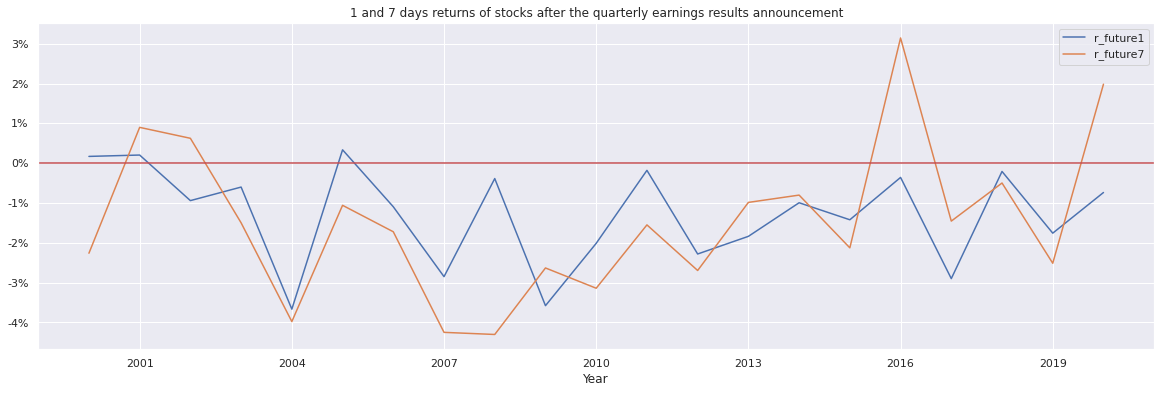

In [ ]:

# [[RESULT 5-2]] We try the parametrised approach: get the returns r1 and r7 for different classes of stocks (EPS<0, EPS>0, EPS>1, EPS>2 etc.) 
   #  ==> we want to find one line (r7) is always higher than another line (r1) 
   # --> but can't actually prove that it is true (unfortunatelly)
draw_returns('Year', merged_df["Reported EPS"]<0)

Count observations:  Year
2000     6
2001     9
2002    10
2003     5
2004     4
2005     4
2006     7
2007     8
2008    28
2009    24
2010    12
2011     5
2012     2
2013     1
2014     1
2016     8
2017     6
2018     6
2019    19
2020    58
Name: r_future1, dtype: int64


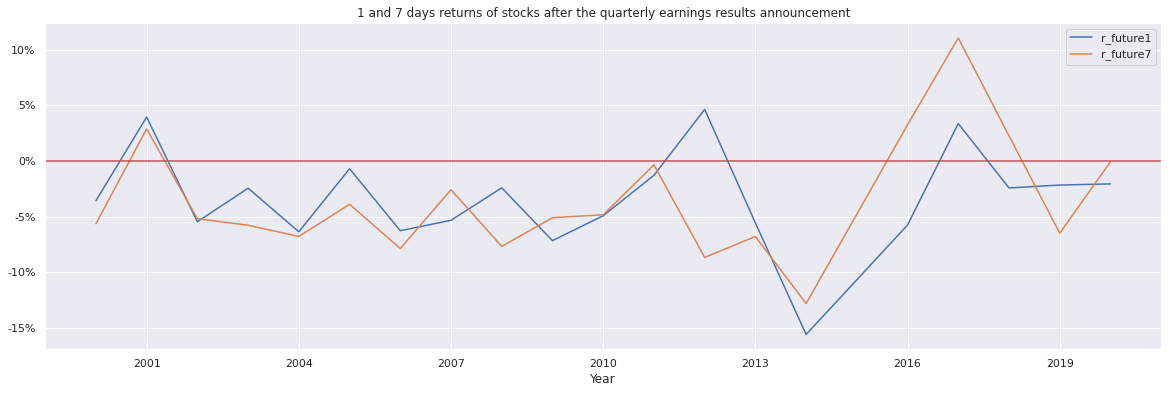

In [ ]:
draw_returns('Year', merged_df["Reported EPS"]<-1)

Count observations:  Year
2000    365
2001    351
2002    367
2003    388
2004    415
2005    421
2006    456
2007    466
2008    445
2009    411
2010    467
2011    484
2012    483
2013    522
2014    538
2015    527
2016    516
2017    551
2018    591
2019    603
2020    523
Name: r_future1, dtype: int64


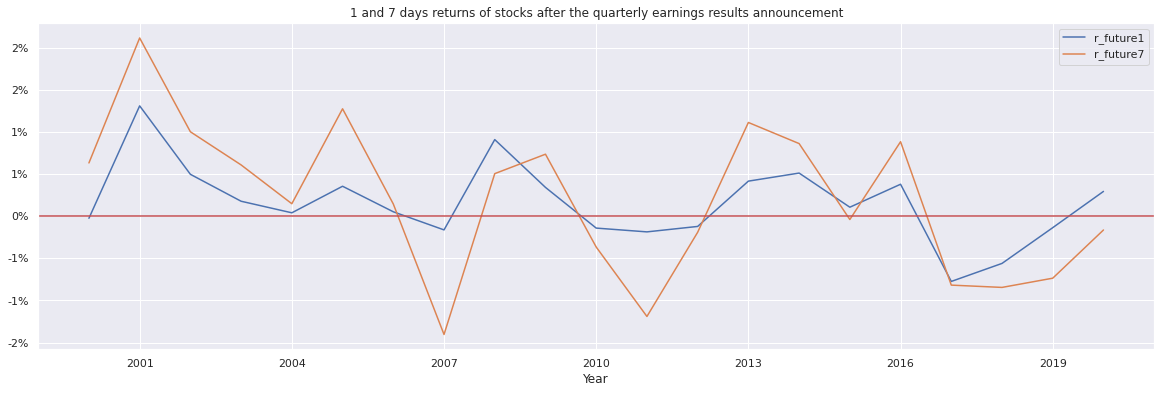

In [ ]:
draw_returns('Year', merged_df["Reported EPS"]>0)

Count observations:  Year
2000     25
2001     30
2002     20
2003     21
2004     35
2005     58
2006     76
2007     98
2008     86
2009     41
2010     81
2011    112
2012     96
2013    106
2014    132
2015    130
2016    130
2017    145
2018    190
2019    200
2020    166
Name: r_future1, dtype: int64


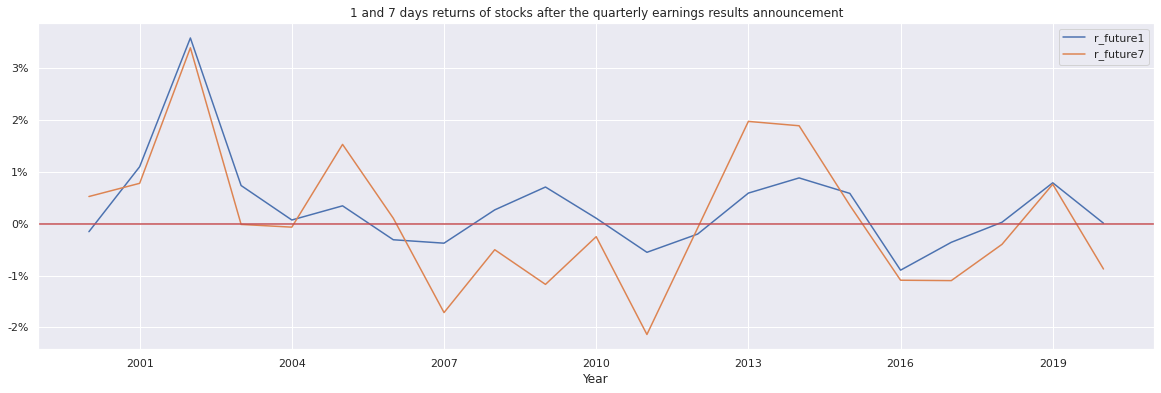

In [ ]:
draw_returns('Year', merged_df["Reported EPS"]>1)

Count observations:  Year
2000     9
2001     8
2002     8
2003    10
2004    10
2005    13
2006    23
2007    21
2008    29
2009     4
2010     7
2011    19
2012    18
2013    12
2014    18
2015    21
2016    19
2017    26
2018    40
2019    45
2020    38
Name: r_future1, dtype: int64


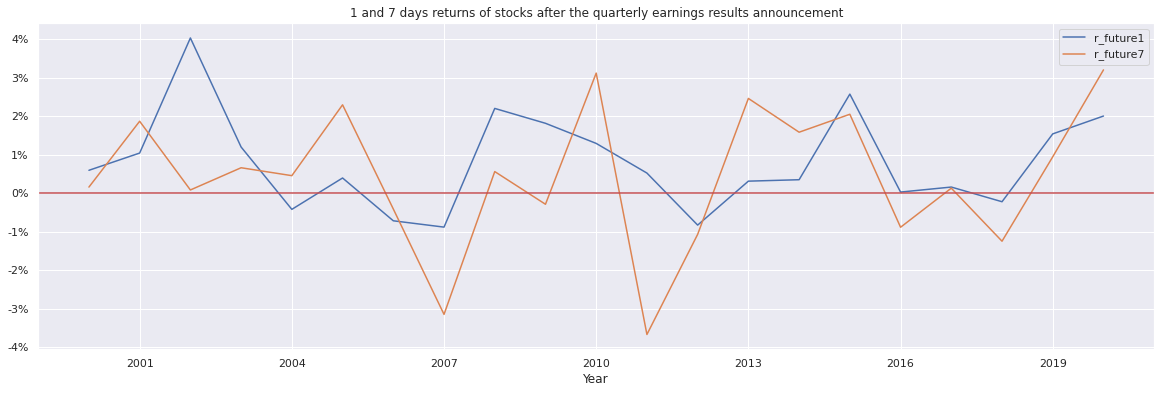

In [ ]:
draw_returns('Year', merged_df["Reported EPS"]>2)

## 6.2) Try to slice the data on the volume of trade /size of a company

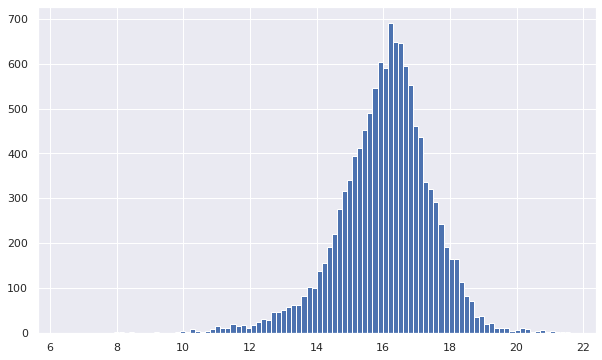

In [ ]:
merged_df.ln_volume.replace([np.inf, -np.inf], np.nan).hist(bins=100)

In [ ]:
merged_df["ln_volume_binned"] = pd.qcut(merged_df["ln_volume"],10)

In [ ]:
merged_df.ln_volume_binned.value_counts()

(17.674, 21.613]    1226
(6.396, 14.344]     1226
(17.111, 17.674]    1225
(16.74, 17.111]     1225
(16.436, 16.74]     1225
(16.157, 16.436]    1225
(15.85, 16.157]     1225
(15.49, 15.85]      1225
(15.037, 15.49]     1225
(14.344, 15.037]    1225
Name: ln_volume_binned, dtype: int64

Count observations:  ln_volume_binned
(6.396, 14.344]      727
(14.344, 15.037]     933
(15.037, 15.49]     1045
(15.49, 15.85]      1084
(15.85, 16.157]     1120
(16.157, 16.436]    1146
(16.436, 16.74]     1148
(16.74, 17.111]     1185
(17.111, 17.674]    1184
(17.674, 21.613]    1126
Name: r_future1, dtype: int64


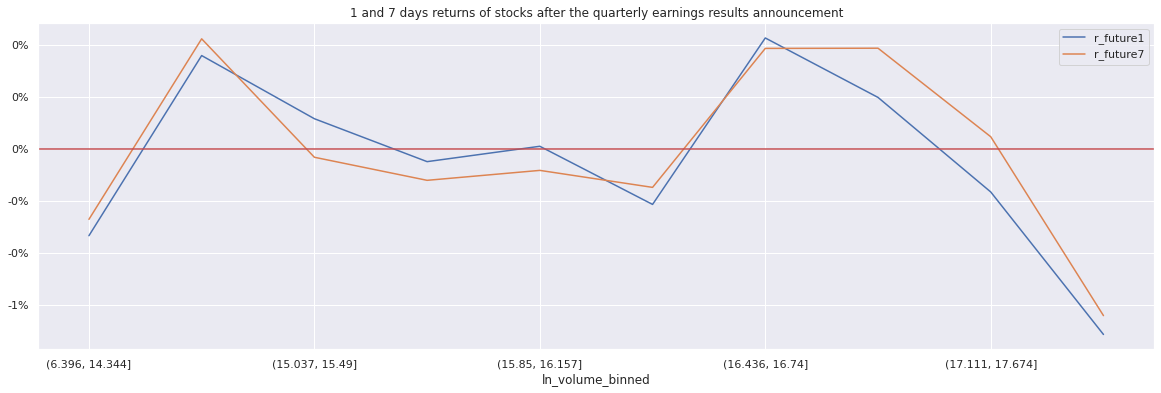

In [ ]:



# [[RESULT 5-3]] We try the parametrised approach: get the returns r1 and r7 for different classes of stocks regarding their size-volume of trade 
    #  Same idea as 5-2, and again no success in the riskless trading strategy
    #  Side effect: large companies tend to have negative returns after the earnings calls in 2010-2019, but in 2020 - largest companies have in average positive returns

# It used to be: Large companies tend to have a small negative returns after the earnings date

draw_returns('ln_volume_binned', merged_df["Year"]>2000)

Count observations:  ln_volume_binned
(6.396, 14.344]       8
(14.344, 15.037]     32
(15.037, 15.49]      46
(15.49, 15.85]       63
(15.85, 16.157]      80
(16.157, 16.436]    103
(16.436, 16.74]      97
(16.74, 17.111]     103
(17.111, 17.674]     95
(17.674, 21.613]     89
Name: r_future1, dtype: int64


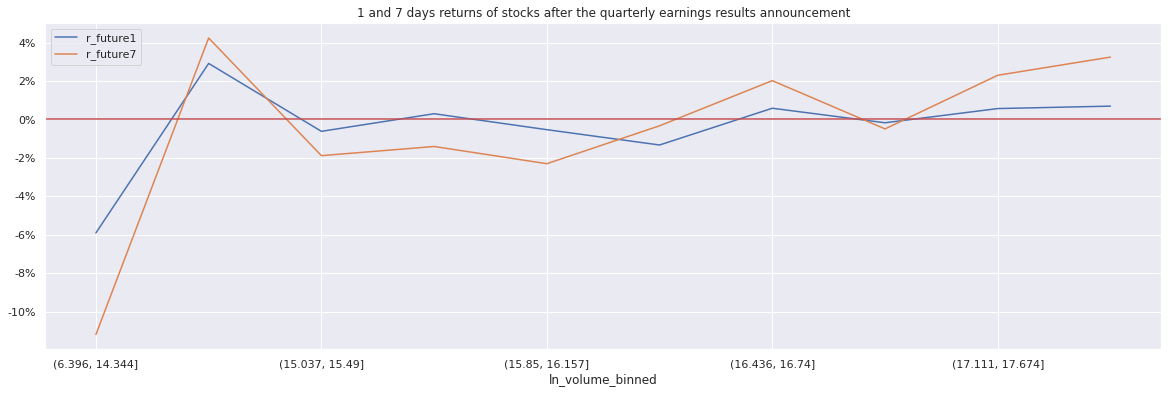

In [ ]:
# In 2020 : Large companies have positive returns anyway

draw_returns('ln_volume_binned', merged_df["Year"]==2020)

Count observations:  ln_volume_binned
(6.396, 14.344]      3
(14.344, 15.037]    26
(15.037, 15.49]     35
(15.49, 15.85]      50
(15.85, 16.157]     60
(16.157, 16.436]    79
(16.436, 16.74]     80
(16.74, 17.111]     69
(17.111, 17.674]    72
(17.674, 21.613]    49
Name: r_future1, dtype: int64


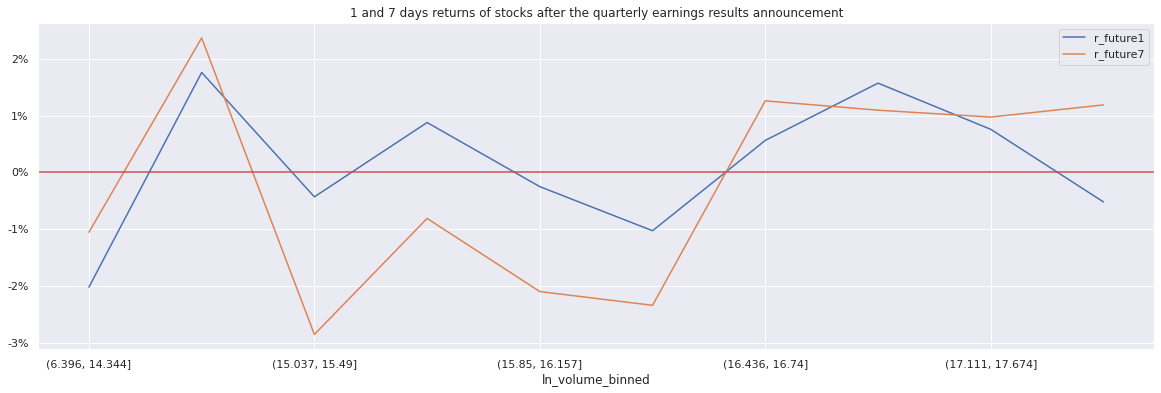

In [ ]:
draw_returns('ln_volume_binned', (merged_df["Year"]==2020) & (merged_df["Reported EPS"]>0))

Count observations:  ln_volume_binned
(6.396, 14.344]      5
(14.344, 15.037]     6
(15.037, 15.49]     11
(15.49, 15.85]      13
(15.85, 16.157]     20
(16.157, 16.436]    24
(16.436, 16.74]     17
(16.74, 17.111]     34
(17.111, 17.674]    23
(17.674, 21.613]    40
Name: r_future1, dtype: int64


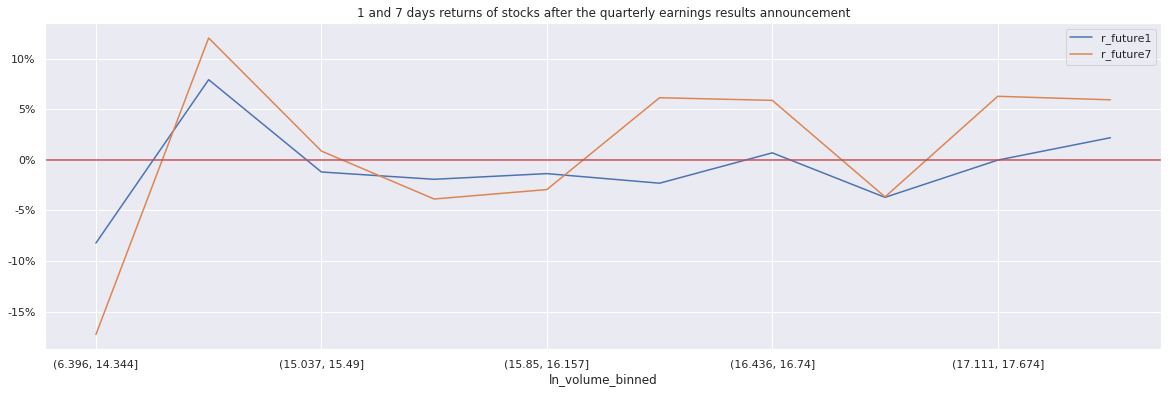

In [ ]:
draw_returns('ln_volume_binned', (merged_df["Year"]==2020) & (merged_df["Reported EPS"]<0))

## 6.3) Analyse the Surprise % value

count    12252.000000
mean         0.985261
std        391.866902
min     -31360.230000
25%         -0.930000
50%          3.730000
75%         13.460000
max       6900.000000
Name: Surprise(%), dtype: float64


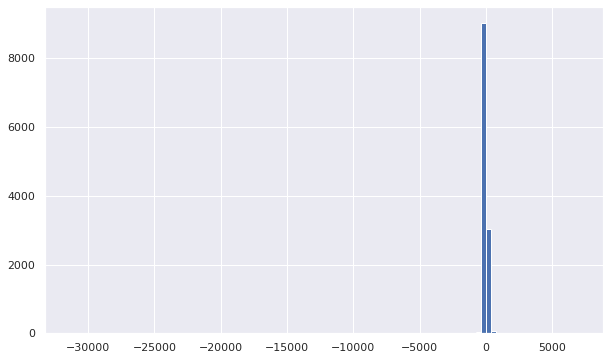

In [ ]:
# Surprise is largely concentrated around 0 , as many companies want to report the very close value  
print(merged_df['Surprise(%)'].describe())
merged_df['Surprise(%)'].hist(bins=100)

In [ ]:
# Create 10 equal bins of data for surprise
merged_df["surprise_%_binned"] = pd.qcut(merged_df["Surprise(%)"],10)

In [ ]:
# The bins values
merged_df["surprise_%_binned"].sort_values().value_counts()

(-3.39, 0.27]            1229
(36.469, 6900.0]         1226
(10.677, 17.52]          1226
(1.87, 3.73]             1226
(-17.356, -3.39]         1226
(-31360.231, -17.356]    1226
(6.446, 10.677]          1225
(17.52, 36.469]          1224
(3.73, 6.446]            1223
(0.27, 1.87]             1221
Name: surprise_%_binned, dtype: int64

Count observations:  surprise_%_binned
(-31360.231, -17.356]    1121
(-17.356, -3.39]         1117
(-3.39, 0.27]            1053
(0.27, 1.87]             1066
(1.87, 3.73]             1093
(3.73, 6.446]            1100
(6.446, 10.677]          1119
(10.677, 17.52]          1122
(17.52, 36.469]          1139
(36.469, 6900.0]         1158
Name: r_future1, dtype: int64


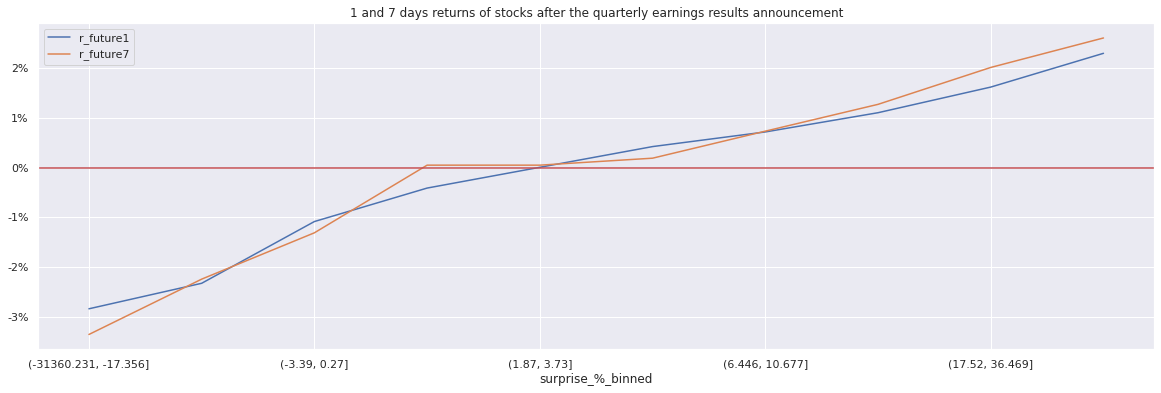

In [ ]:
# [[RESULT 5-4]] We try the parametrised approach: get the returns r1 and r7 for different classes of stocks regarding their Surprise(%) in EPS 

  # It is one of the most consistent results: if Surprise is negative (say, Surprise<0) --> r1 and r7 are <0 and close to each other , if Surprise is positive - r1 and r7 are >0, and if Surprise >20% -> the expected spike is ~1.5% for r1 and r7.
  # AND r7 is higher than r1 only in outstanding cases when Surprise(%)>43%
  #  THAT IS THE INVEST IDEA: invest in those stocks when Surprise>43% , the problem is that it is not much of such occasions...

# Larger the surprise --> better are the returns
  # Interesting fact: if Surprise>36% --> then r1 returns are positive, and more than that r7 returns are even higher
                    # if Surprise<-15% --> there is a difference between r1 and r7 again
draw_returns('surprise_%_binned', True)

Count observations:  Year
2000    390
2001    395
2002    413
2003    427
2004    439
2005    444
2006    484
2007    499
2008    506
2009    500
2010    512
2011    523
2012    534
2013    567
2014    577
2015    603
2016    612
2017    612
2018    638
2019    697
2020    716
Name: r_future1, dtype: int64


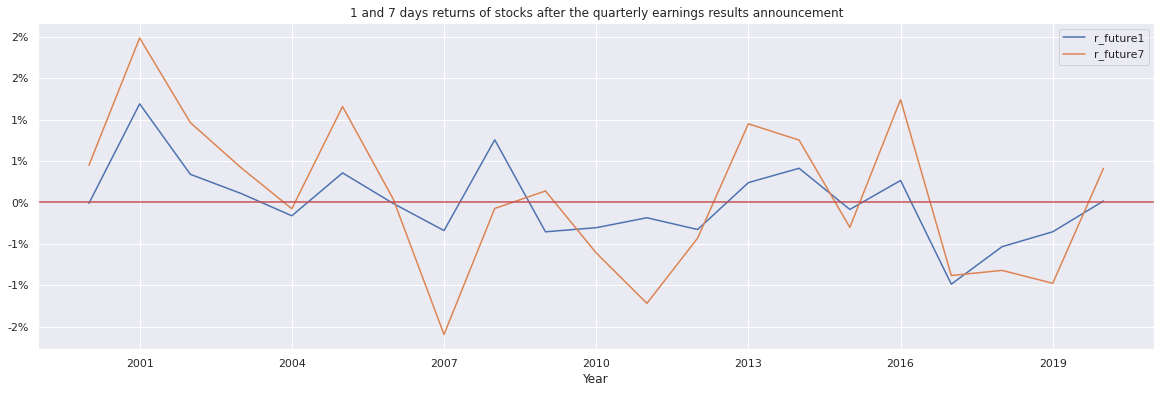

In [ ]:
#  Average number of reports per year
draw_returns('Year', True)

Count observations:  Year
2000     25
2001     17
2002     31
2003     25
2004     29
2005     23
2006     26
2007     27
2008     44
2009     75
2010     51
2011     37
2012     41
2013     47
2014     47
2015     65
2016     67
2017     66
2018     57
2019     66
2020    129
Name: r_future1, dtype: int64


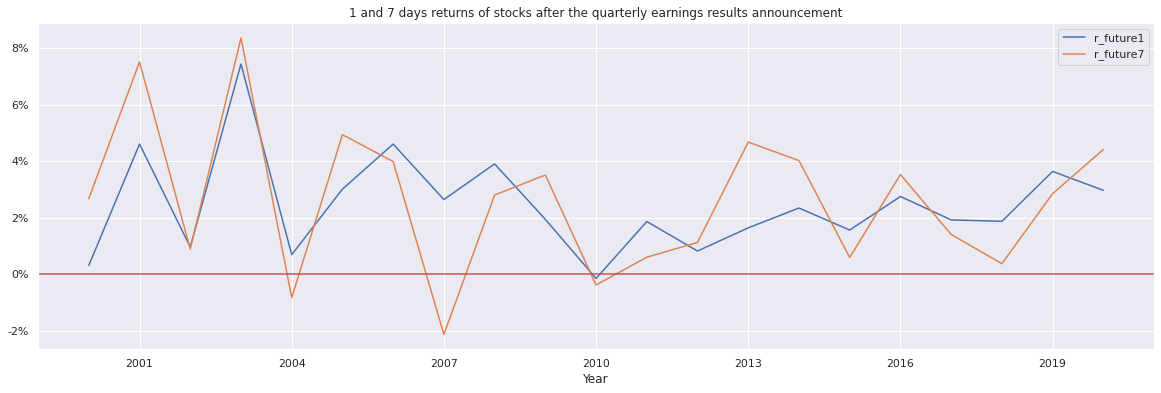

In [ ]:
#  Average number of reports per year WITH Surprise>43% is ~10-20% (rising from 10% in the past to 20% in 2020)
draw_returns('Year', merged_df['Surprise(%)'] >=43)

Count observations:  Year
2000    390
2001    395
2002    413
2003    427
2004    439
2005    444
2006    484
2007    499
2008    506
2009    500
2010    512
2011    523
2012    534
2013    567
2014    577
2015    603
2016    612
2017    612
2018    638
2019    697
2020    716
Name: r_future1, dtype: int64


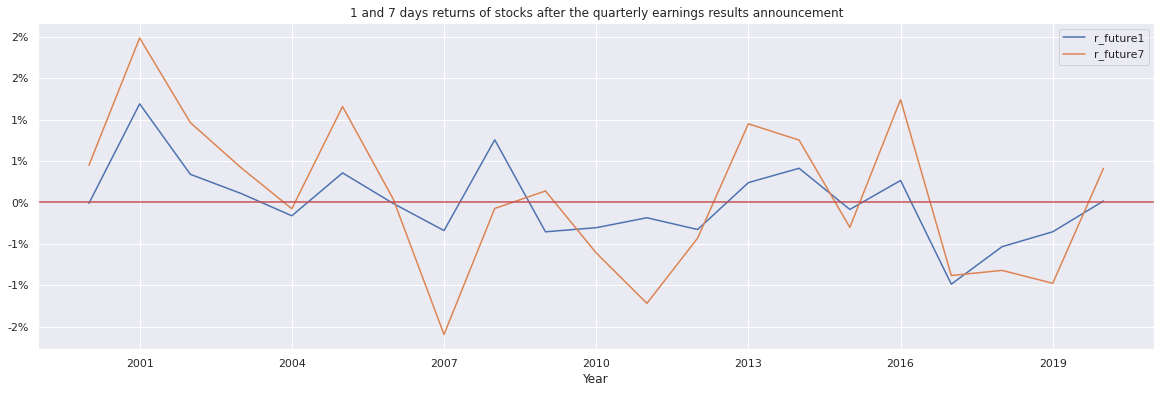

In [ ]:
# Returns by years
draw_returns('Year', True)

Count observations:  Year
2000    224
2001    233
2002    209
2003    221
2004    239
2005    233
2006    264
2007    246
2008    239
2009    166
2010    253
2011    278
2012    261
2013    278
2014    314
2015    283
2016    292
2017    300
2018    318
2019    313
2020    216
Name: r_future1, dtype: int64


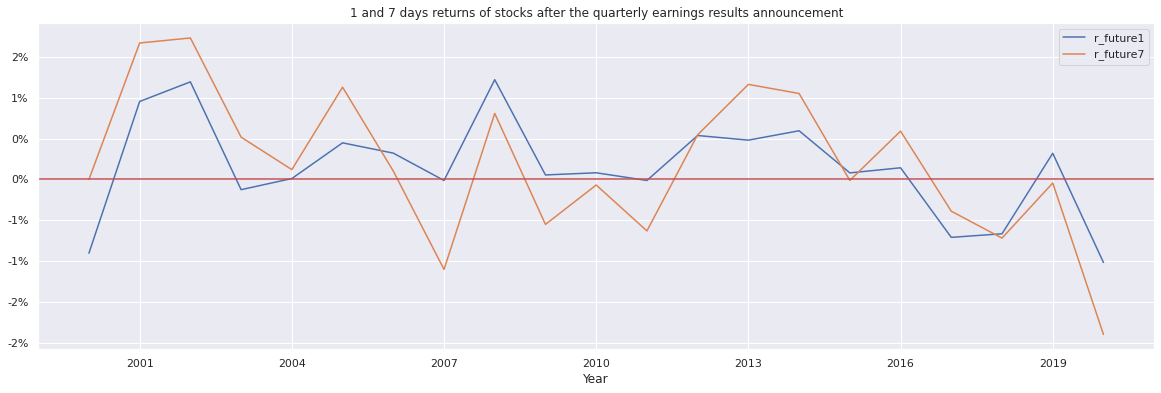

In [ ]:
# Returns by years for the normal values of surprise (25% .. 75% quantile)

#  Normal case : when EPS reported as expected ==> tend to decline as the market
draw_returns('Year', (merged_df['Surprise(%)'] >=-1) & (merged_df['Surprise(%)']<=13))

Count observations:  Year
2000     78
2001     79
2002    107
2003     94
2004    104
2005    102
2006    111
2007    133
2008    155
2009    144
2010    111
2011    127
2012    156
2013    152
2014    127
2015    166
2016    156
2017    140
2018    130
2019    182
2020    209
Name: r_future1, dtype: int64


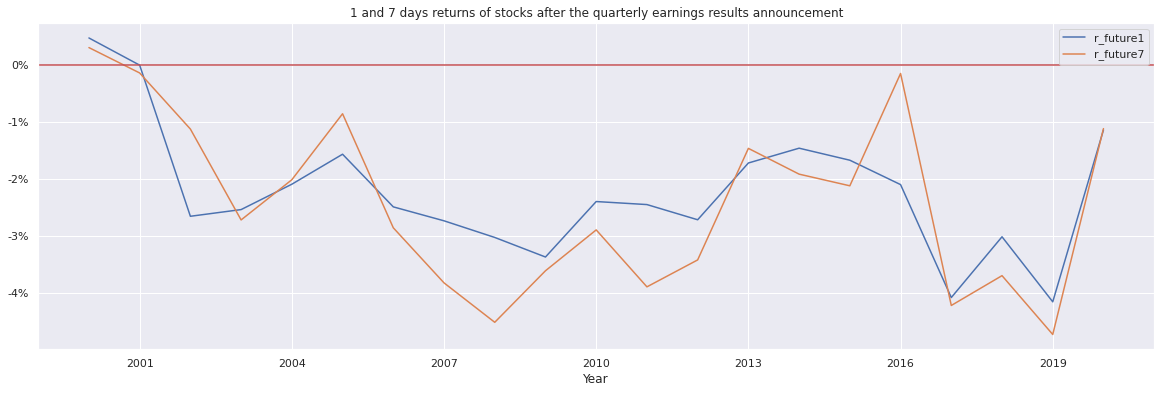

In [ ]:
# Negative returns if Surprise is <0
draw_returns('Year', merged_df['Surprise(%)']<-1)

Count observations:  Year
2000     88
2001     83
2002     97
2003    112
2004     96
2005    109
2006    109
2007    120
2008    112
2009    190
2010    148
2011    118
2012    117
2013    137
2014    136
2015    154
2016    164
2017    172
2018    190
2019    202
2020    291
Name: r_future1, dtype: int64


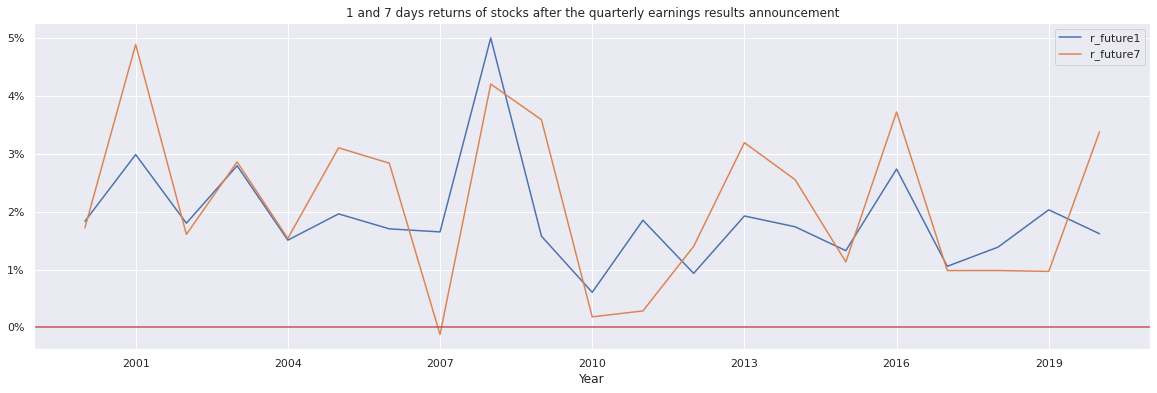

In [ ]:
# Very positive returns if Surprise >13
draw_returns('Year', merged_df['Surprise(%)']>13)

Count observations:  Year
2000     9
2001     9
2002     9
2003    10
2004    12
2005     9
2006    10
2007     9
2008    18
2009    31
2010    23
2011    15
2012    12
2013    22
2014    18
2015    27
2016    30
2017    31
2018    24
2019    32
2020    65
Name: r_future1, dtype: int64


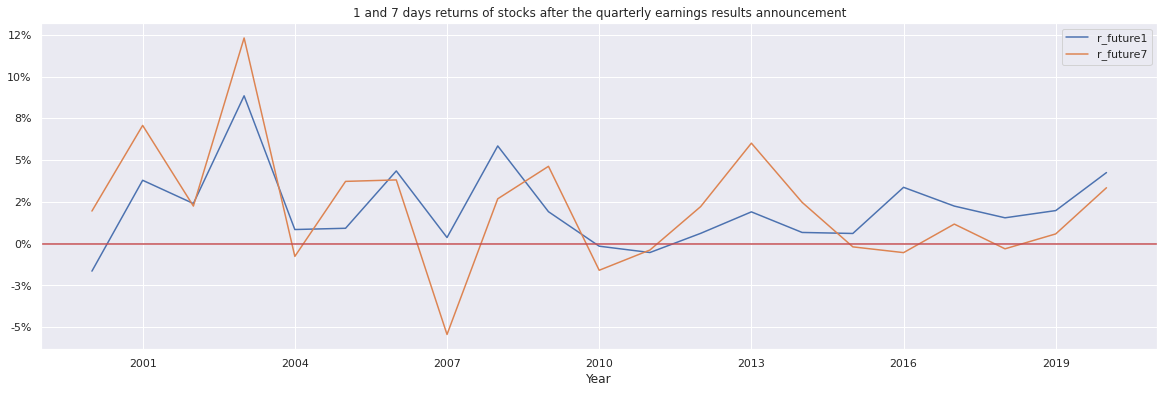

In [ ]:
# Very good surprise --> the effect of rapid growth is neglected in 7 days
draw_returns('Year', merged_df['Surprise(%)']>100)

## 6.4) What is better r2-r1, r3-r1 ,... r30-r1 how long can we catch the moment of high/low spike?


In [ ]:
merged_df["r2_r1"] = merged_df.r_future2 -  merged_df.r_future1
merged_df["r3_r1"] = merged_df.r_future3 -  merged_df.r_future1
merged_df["r4_r1"] = merged_df.r_future4 -  merged_df.r_future1
merged_df["r5_r1"] = merged_df.r_future5 -  merged_df.r_future1
merged_df["r6_r1"] = merged_df.r_future6 -  merged_df.r_future1
merged_df["r7_r1"] = merged_df.r_future7 -  merged_df.r_future1
merged_df["r30_r1"] = merged_df.r_future30 -  merged_df.r_future1

In [ ]:
filter = (merged_df['Surprise(%)']>13)
ddf = merged_df[["r_future1","r2_r1","r3_r1","r4_r1","r5_r1","r6_r1","r7_r1","r30_r1"]]
ddf_filtered = ddf[filter]

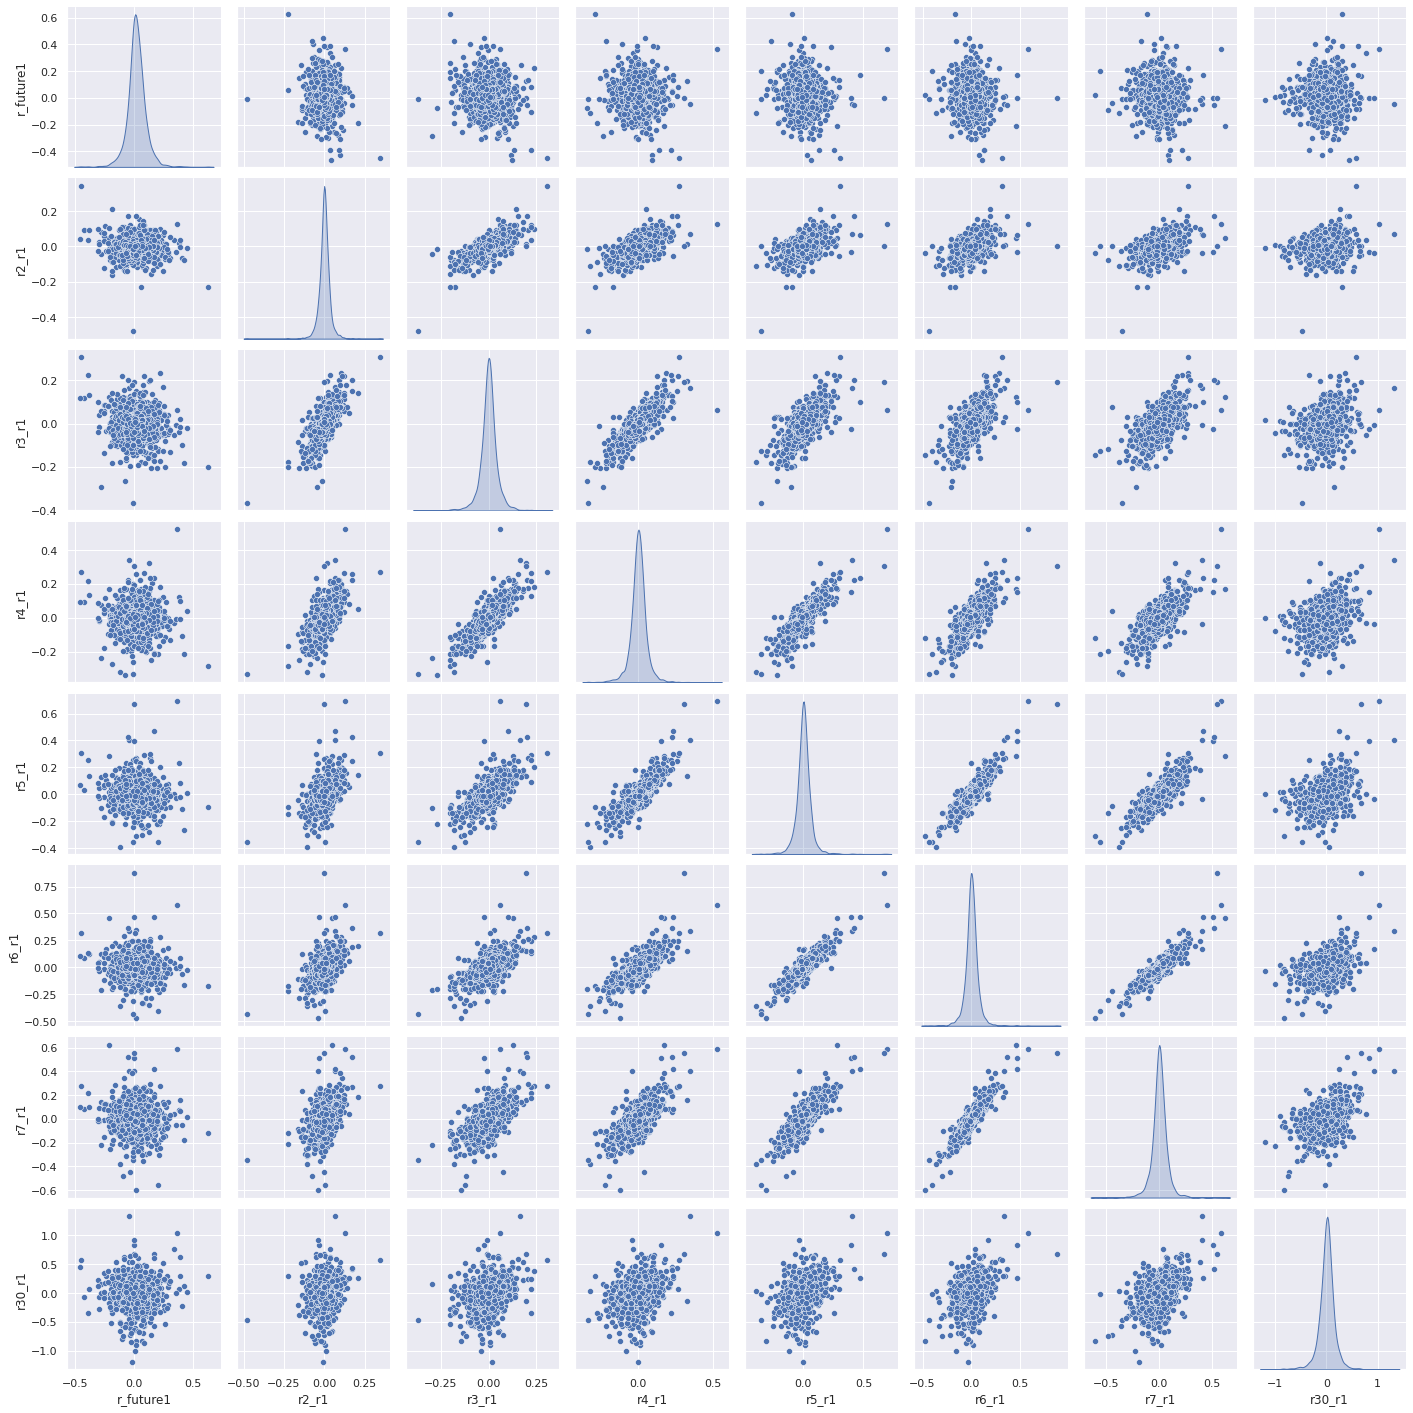

In [ ]:
# Graph idea is from here: https://www.tensorflow.org/tutorials/keras/regression
sns.pairplot(ddf_filtered, diag_kind='kde')

In [ ]:
ddf_filtered.describe().transpose()

count      mean       std  ...       50%       75%       max
r_future1  3147.0  0.018625  0.078192  ...  0.016443  0.058836  0.627941
r2_r1      3144.0 -0.000235  0.033968  ...  0.000000  0.015602  0.343771
r3_r1      3140.0  0.000012  0.044645  ...  0.000337  0.020203  0.306731
r4_r1      3137.0  0.001104  0.054566  ...  0.001831  0.027096  0.523394
r5_r1      3133.0  0.002085  0.062428  ...  0.002152  0.029972  0.693147
r6_r1      3131.0  0.001990  0.069076  ...  0.001819  0.032968  0.877451
r7_r1      3126.0  0.002750  0.075958  ...  0.002831  0.038204  0.625724
r30_r1     3055.0  0.003342  0.159932  ...  0.010292  0.080273  1.325434

[8 rows x 8 columns]

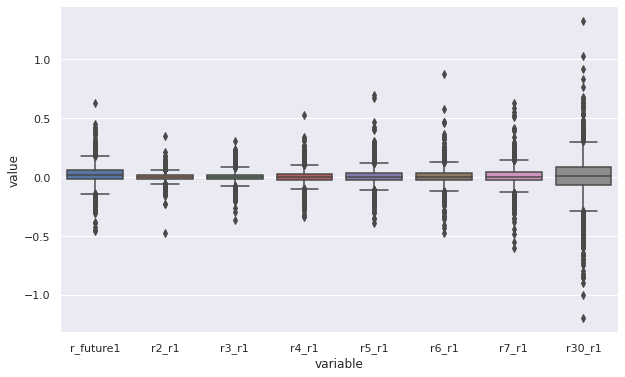

In [ ]:
sns.boxplot(x="variable", y="value", data=pd.melt(ddf_filtered))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd77ef77a58>,
      dtype=object)

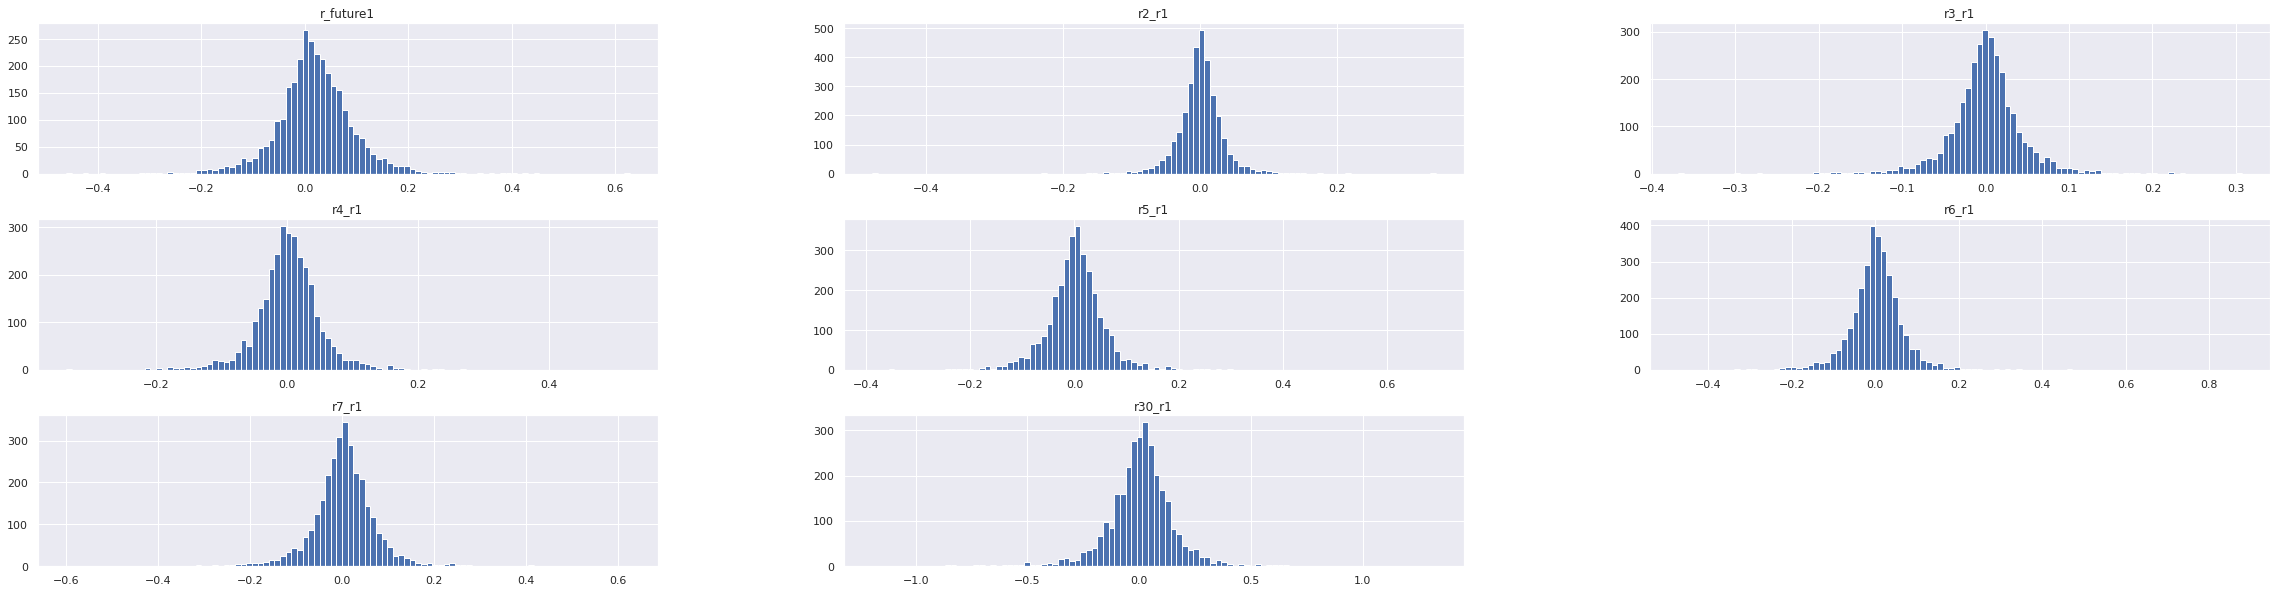

In [ ]:
ddf_filtered.hist(figsize=(40,10), bins=100)

## 6.5) Implement prediction of r_future7,30,90,365 as f(eps, surprise, size, year? --> and lagged values)

Article: https://towardsdatascience.com/time-series-modeling-using-scikit-pandas-and-numpy-682e3b8db8d1